# Run torsion scans

In [1]:
import os
import pickle
import numpy as np
from openmmtools.integrators import LangevinIntegrator
from openmmtools.states import ThermodynamicState, CompoundThermodynamicState, SamplerState
from perses.annihilation.lambda_protocol import RelativeAlchemicalState, LambdaProtocol, AlchemicalState
from openmmtools.alchemy import AbsoluteAlchemicalFactory, AlchemicalRegion, AlchemicalState
from simtk import openmm, unit
from tqdm import tqdm
import mdtraj as md
from openmmtools.mcmc import MCDihedralRotationMove, LangevinSplittingDynamicsMove
import math
from matplotlib import pyplot as plt
import logging
import copy
from openmmtools import cache
import scipy
from perses.tests.test_topology_proposal import generate_atp, generate_dipeptide_top_pos_sys


logger = logging.getLogger()
logger.setLevel(logging.INFO)


DEBUG:matplotlib:(private) matplotlib data path: /home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:matplotlib data path: /home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/home/zhangi/.config/matplotlib
DEBUG:matplotlib:matplotlib version 3.3.2
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', '_bootlocale', '_locale', 'site', 'os', 'stat', '_stat', '_collections_abc', 'posixpath', 'genericpath', 'os.path', '_sitebuiltins', 'types', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warn

DEBUG:matplotlib:CACHEDIR=/home/zhangi/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/zhangi/.cache/matplotlib/fontlist-v330.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
INFO:rdkit:Enabling RDKit 2020.09.1 jupyter extensions


### Define helper function for running short MD

In [2]:
# outdir = "/data/chodera/zhangi/perses_benchmark/neq/7/5/"
# with open(os.path.join(outdir, "5_vacuum.pickle" ), "rb") as f:
#     htf = pickle.load(f)

# # Define simulation parameters
# temperature = 300 * unit.kelvin
# nsteps = 10000
# timestep = 2.0 * unit.femtosecond
# platform_name = 'CUDA'
# collision_rate = 1.0 / unit.picoseconds

# system = htf.hybrid_system
# positions = htf.hybrid_positions

# # Create CompoundThermodynamicState at the appropriate endstate
# lambda_alchemical_state = RelativeAlchemicalState.from_system(system)
# lambda_protocol = LambdaProtocol(functions = 'default')
# lambda_alchemical_state.set_alchemical_parameters(0, lambda_protocol)
# thermodynamic_state = CompoundThermodynamicState(ThermodynamicState(system, temperature=temperature), composable_states=[lambda_alchemical_state])

# # Set up integrator
# integrator = LangevinIntegrator(temperature, collision_rate, timestep)

# # Set up context
# platform = openmm.Platform.getPlatformByName(platform_name)
# if platform_name in ['CUDA', 'OpenCL']:
#     platform.setPropertyDefaultValue('Precision', 'mixed')
# if platform_name in ['CUDA']:
#     platform.setPropertyDefaultValue('DeterministicForces', 'true')

# context = thermodynamic_state.create_context(integrator, platform=platform)

In [3]:
# swigs = context.getParameters()
# context_parameters = {q: swigs[q] for q in swigs}
# print(context_parameters)


In [4]:
def run_md(htf, endstate, repartitioned=False):

    # Define simulation parameters
    temperature = 300 * unit.kelvin
    nsteps = 10000
    timestep = 4.0 * unit.femtosecond
    platform_name = 'CUDA'
    collision_rate = 1.0 / unit.picoseconds

    system = htf.hybrid_system
    positions = htf.hybrid_positions

    if not repartitioned:
        # Create CompoundThermodynamicState at the appropriate endstate
        lambda_alchemical_state = RelativeAlchemicalState.from_system(system)
        lambda_protocol = LambdaProtocol(functions = 'default')
        lambda_alchemical_state.set_alchemical_parameters(endstate, lambda_protocol)
        thermodynamic_state = CompoundThermodynamicState(ThermodynamicState(system, temperature=temperature), composable_states=[lambda_alchemical_state])
    else:  
        # Alchemify the hybrid system
        atoms_to_alchemify = list(htf._atom_classes['unique_new_atoms']) + list(htf._atom_classes['unique_old_atoms'])

        alch_factory = AbsoluteAlchemicalFactory(consistent_exceptions=False)
        alchemical_region = AlchemicalRegion(alchemical_atoms=list(atoms_to_alchemify), alchemical_torsions=True)
        alchemical_system = alch_factory.create_alchemical_system(htf.hybrid_system, alchemical_region)
        alchemical_state = AlchemicalState.from_system(alchemical_system)
        alchemical_state.set_alchemical_parameters(endstate)
        thermodynamic_state = CompoundThermodynamicState(ThermodynamicState(alchemical_system, temperature=temperature), composable_states=[alchemical_state])

    # Set up integrator
    integrator = LangevinIntegrator(temperature, collision_rate, timestep)

    # Set up context
    platform = openmm.Platform.getPlatformByName(platform_name)
    if platform_name in ['CUDA', 'OpenCL']:
        platform.setPropertyDefaultValue('Precision', 'mixed')
    if platform_name in ['CUDA']:
        platform.setPropertyDefaultValue('DeterministicForces', 'true')
        
    context = thermodynamic_state.create_context(integrator, platform=platform)    
#     context, integrator = cache.global_context_cache.get_context(thermodynamic_state, integrator)
#     print(context.getParameter('lambda_angles'))
        
    context.setPeriodicBoxVectors(*system.getDefaultPeriodicBoxVectors())
    context.setPositions(positions)
    context.setVelocitiesToTemperature(temperature)
    print(thermodynamic_state.reduced_potential(context))
    
    md.Trajectory(np.array(htf.old_positions(positions)), md.Topology.from_openmm(htf._topology_proposal.old_topology)).save("nan_before_minimize.pdb")


    # Minimize
    openmm.LocalEnergyMinimizer.minimize(context)

    # Run equilibration
    for step in tqdm(range(nsteps)):
        integrator.step(1)
    
    return context, thermodynamic_state

### Sub-class MCDihedralRotationMove

In [5]:
# 1) Remove metropolize part in apply()
# 2) Pass -theta to compute_dihedral()

class MCDihedralRotationMove2(MCDihedralRotationMove):
    def rotate_positions(self, initial_positions):
        """Apply rotation to atom_subset positions.
        Parameters
        ----------
        initial_positions : numpy.ndarray simtk.unit.Quantity
            The positions of all atoms in atom_subset.
        Returns
        -------
        rotated_positions : numpy.ndarray simtk.unit.Quantity
            The rotated positions.
        """
        import math
        import copy
        import numpy as np 
        import logging
        logger = logging.getLogger()
        
        old_angle = self.compute_dihedral(initial_positions[:4])

        if self.desired_angle == -np.inf:
            # Choose a random rotation angle
            theta = random.uniform(-math.pi, math.pi)
        else:
            # If desired_angle is specified, determine rotation angle
            if not (self.desired_angle <= math.pi and self.desired_angle >= -math.pi):
                raise Exception("Desired angle must be less than pi and greater than -pi")
            theta = self.desired_angle - old_angle
        logger.info(f"Rotating by {theta} radians")

        # Make a copy of the initial positions
        new_positions = copy.deepcopy(initial_positions)

        # Find the rotation axis using the initial positions
        axis1 = 1
        axis2 = 2
        rotation_axis = (initial_positions[axis1] - initial_positions[axis2]) / initial_positions.unit

        # Calculate the rotation matrix
        rotation_matrix = self.generate_rotation_matrix(rotation_axis, -theta) ## CHANGED theta to negative

        # Apply the rotation matrix to the target atoms
        for atom_index in range(3, len(self.atom_subset)):
            # Find the reduced position (substract out axis)
            reduced_position = (initial_positions[atom_index] - initial_positions[axis2])._value

            # Find the new positions by multiplying by rot matrix
            new_position = np.dot(rotation_matrix, reduced_position) * initial_positions.unit + initial_positions[axis2]

            # Update the new positions
            new_positions[atom_index][0] = new_position[0]
            new_positions[atom_index][1] = new_position[1]
            new_positions[atom_index][2] = new_position[2]
        
        return new_positions
    def apply(self, thermodynamic_state, sampler_state):
        """Apply a metropolized move to the sampler state.
        Total number of acceptances and proposed move are updated.
        Parameters
        ----------
        thermodynamic_state : openmmtools.states.ThermodynamicState
           The thermodynamic state to use to apply the move.
        sampler_state : openmmtools.states.SamplerState
           The initial sampler state to apply the move to. This is modified.
        """
#         from openmmtools import cache
        import copy
#         timer = Timer()
#         benchmark_id = 'Applying {}'.format(self.__class__.__name__ )
#         timer.start(benchmark_id)

        # Check if we have to use the global cache.
        if self.context_cache is None:
            context_cache = cache.global_context_cache
        else:
            context_cache = self.context_cache

        # Create context, any integrator works.
        context, unused_integrator = context_cache.get_context(thermodynamic_state)
        
        # Compute initial energy. We don't need to set velocities to compute the potential.
        # TODO assume sampler_state.potential_energy is the correct potential if not None?
        sampler_state.apply_to_context(context, ignore_velocities=True)
        initial_energy = thermodynamic_state.reduced_potential(context)

        # Handle default and weird cases for atom_subset.
        if self.atom_subset is None:
            atom_subset = slice(None)
        elif not isinstance(self.atom_subset, slice) and len(self.atom_subset) == 1:
            # Slice so that initial_positions (below) will have a 2D shape.
            atom_subset = slice(self.atom_subset[0], self.atom_subset[0]+1)
        else:
            atom_subset = self.atom_subset

        # Store initial positions of the atoms that are moved.
        # We'll use this also to recover in case the move is rejected.
        if isinstance(atom_subset, slice):
            # Numpy array when sliced return a view, they are not copied.
            initial_positions = copy.deepcopy(sampler_state.positions[atom_subset])
        else:
            # This automatically creates a copy.
            initial_positions = sampler_state.positions[atom_subset]

        # Propose perturbed positions. Modifying the reference changes the sampler state.
        proposed_positions = self._propose_positions(initial_positions)

        # Compute the energy of the proposed positions.
        sampler_state.positions[atom_subset] = proposed_positions
        sampler_state.apply_to_context(context, ignore_velocities=True)
        proposed_energy = thermodynamic_state.reduced_potential(context)

#         # Accept or reject with Metropolis criteria.
#         delta_energy = proposed_energy - initial_energy
#         if (not np.isnan(proposed_energy) and
#                 (delta_energy <= 0.0 or np.random.rand() < np.exp(-delta_energy))):
#             self.n_accepted += 1
#         else:
#             # Restore original positions.
#             sampler_state.positions[atom_subset] = initial_positions
#         self.n_proposed += 1

#         # Print timing information.
#         timer.stop(benchmark_id)
#         #timer.report_timing()
        
        return proposed_energy, sampler_state.positions

### Define run torsion scan function

In [15]:
def run_torsion_scan(htf, endstate, is_old, hybrid_indices, vanilla_indices, other_indices, repartitioned=False):
    """
    hybrid_indices : list of int
        indices of the dihedral atoms from the hybrid system
    vanilla_indices : list of int
        indices of the dihedral atoms from the vanilla (old or new) system
    other_indices : list of int
        indices of the non-dihedral sidechain atoms to be rotated, from the hybrid system
    """
    
#     d_masses = {}
#     # Set particle masses to 0
#     for index in hybrid_indices:
#         d_masses[index] = htf.hybrid_system.getParticleMass(index)
#         htf.hybrid_system.setParticleMass(index, 0.0)
    
#     # Turn off constraints involving massless particles
#     for i in reversed(range(htf.hybrid_system.getNumConstraints())):
#         p1, p2, d = htf.hybrid_system.getConstraintParameters(i)
#         if p1 in hybrid_indices or p2 in hybrid_indices:
#             if htf.hybrid_system.getParticleMass(p1) == 0*unit.amu or htf.hybrid_system.getParticleMass(p2) == 0*unit.amu:
#                 htf.hybrid_system.removeConstraint(i)
    
    # Run MD
    context, thermodynamic_state = run_md(htf, endstate, repartitioned=repartitioned)
    
    # Create sampler state
    sampler_state = SamplerState.from_context(context)
    
    # Compute current dihedral
    if is_old:
        dihedral = md.compute_dihedrals(md.Trajectory(np.array(htf.old_positions(htf.hybrid_positions)), 
                                                      md.Topology.from_openmm(htf._topology_proposal.old_topology)), 
                                        np.array([vanilla_indices]))[0][0]
    else:
        dihedral = md.compute_dihedrals(md.Trajectory(np.array(htf.new_positions(htf.hybrid_positions)), 
                                                      md.Topology.from_openmm(htf._topology_proposal.new_topology)), 
                                        np.array([vanilla_indices]))[0][0]
    print(dihedral)
    
    # Run scan
    d = {} # key : angle, value : energy
    new_dihedral = dihedral + 0.262
    positions_all = []
    for i in range(25):
        # Add correction if the angle is no longer in the domain of [-pi, pi]
        if new_dihedral > math.pi: 
            new_dihedral = -math.pi + (new_dihedral - math.pi)
        elif new_dihedral < -math.pi:
            new_dihedral = math.pi + (new_dihedral + math.pi)
        
        print(thermodynamic_state.reduced_potential(context))
        
        # Apply rotation move
        move = MCDihedralRotationMove2(hybrid_indices + other_indices, desired_angle=new_dihedral) # Rotate the sidechain by 15 degrees
        move.apply(thermodynamic_state, sampler_state)
        
        sampler_state.apply_to_context(context)
#         openmm.LocalEnergyMinimizer.minimize(context)
        energy = thermodynamic_state.reduced_potential(context)
        energies = [energy]
#         sampler_state.update_from_context(context)
        
#         # Apply relaxation move 3x
#         energies = []
#         for i in range(3):
#             relax_move = LangevinSplittingDynamicsMove(timestep=2.0*unit.femtoseconds, collision_rate=1.0/unit.picoseconds, n_steps=10000)
#             relax_move.apply(thermodynamic_state, sampler_state)
#             sampler_state.apply_to_context(context)
#             energy = thermodynamic_state.reduced_potential(context)
#             energies.append(energy)
#             positions = sampler_state.positions

    
        d[new_dihedral] = (np.mean(energies), scipy.stats.sem(energies))
        
#         if is_old:
#             positions_all.append(htf.old_positions(positions)/unit.nanometer) # get last positions from last relaxtion
#         else:
#             positions_all.append(htf.new_positions(positions)/unit.nanometer) # get last positions from last relaxtion
        
        # Increment dihedral angle by 15 degrees
        new_dihedral += 0.262
    
    print(f"raw d: {d}")
        
#     # Write out pdb of positions
#     if is_old:
#         md.Trajectory(np.array(positions_all), md.Topology.from_openmm(htf._topology_proposal.old_topology)).save("traj.pdb")
#     else:
#         md.Trajectory(np.array(positions_all), md.Topology.from_openmm(htf._topology_proposal.new_topology)).save("traj.pdb")
        
    # Plot scan data
    minimum = min([val[0] for val in list(d.values())])
    print(f"min: {minimum}")
    d_corrected = {}
    for k, v in d.items():
        d_corrected[k] = (v[0] - minimum, v[1])
    print(f"d corrected: {d_corrected}")
    plt.errorbar(list(d_corrected.keys()), [mean for mean, stderr in list(d_corrected.values())], yerr=[stderr for mean, stderr in list(d_corrected.values())], fmt='o')
    plt.show()
    
#     # Set masses back to normal
#     for index in hybrid_indices:
#         thermodynamic_state.system.setParticleMass(index, d_masses[index])
#     thermodynamic_state.apply_to_context(context)
    
    return d_corrected
    
    

In [130]:
torsion_scans = []

# 8-mer solvent r-htf lambda = 0

In [40]:
data_dir = "/data/chodera/zhangi/perses_benchmark/neq/10/15/"

with open(os.path.join(data_dir, f"15_solvent_0.pickle"), "rb") as f:
    rhtf = pickle.load(f)

In [41]:
rhtf

#### Look at hybrid and vanilla topologies to determine indices

In [8]:
for atom in rhtf.hybrid_topology.atoms:
    print(atom, atom.index)

ACE0-CH3 0
ACE0-C 1
ACE0-O 2
ACE0-H1 3
ACE0-H2 4
ACE0-H3 5
SER1-N 6
SER1-CA 7
SER1-C 8
SER1-O 9
SER1-CB 10
SER1-OG 11
SER1-H 12
SER1-HA 13
SER1-HB3 14
SER1-HB2 15
SER1-HG 16
SER1-CB 5575
SER1-HB3 5576
SER1-HB2 5577
SER1-HB1 5578
ALA2-N 17
ALA2-CA 18
ALA2-C 19
ALA2-O 20
ALA2-CB 21
ALA2-H 22
ALA2-HA 23
ALA2-HB1 24
ALA2-HB2 25
ALA2-HB3 26
VAL3-N 27
VAL3-CA 28
VAL3-C 29
VAL3-O 30
VAL3-CB 31
VAL3-CG1 32
VAL3-CG2 33
VAL3-H 34
VAL3-HA 35
VAL3-HB 36
VAL3-HG11 37
VAL3-HG12 38
VAL3-HG13 39
VAL3-HG21 40
VAL3-HG22 41
VAL3-HG23 42
LEU4-N 43
LEU4-CA 44
LEU4-C 45
LEU4-O 46
LEU4-CB 47
LEU4-CG 48
LEU4-CD1 49
LEU4-CD2 50
LEU4-H 51
LEU4-HA 52
LEU4-HB3 53
LEU4-HB2 54
LEU4-HG 55
LEU4-HD11 56
LEU4-HD12 57
LEU4-HD13 58
LEU4-HD21 59
LEU4-HD22 60
LEU4-HD23 61
GLN5-N 62
GLN5-CA 63
GLN5-C 64
GLN5-O 65
GLN5-CB 66
GLN5-CG 67
GLN5-CD 68
GLN5-NE2 69
GLN5-OE1 70
GLN5-H 71
GLN5-HA 72
GLN5-HB3 73
GLN5-HB2 74
GLN5-HG3 75
GLN5-HG2 76
GLN5-HE22 77
GLN5-HE21 78
SER6-N 79
SER6-CA 80
SER6-C 81
SER6-O 82
SER6-CB 83
SER6-OG 84

HOH455-H2 1448
HOH456-O 1449
HOH456-H1 1450
HOH456-H2 1451
HOH457-O 1452
HOH457-H1 1453
HOH457-H2 1454
HOH458-O 1455
HOH458-H1 1456
HOH458-H2 1457
HOH460-O 1458
HOH460-H1 1459
HOH460-H2 1460
HOH461-O 1461
HOH461-H1 1462
HOH461-H2 1463
HOH462-O 1464
HOH462-H1 1465
HOH462-H2 1466
HOH463-O 1467
HOH463-H1 1468
HOH463-H2 1469
HOH464-O 1470
HOH464-H1 1471
HOH464-H2 1472
HOH465-O 1473
HOH465-H1 1474
HOH465-H2 1475
HOH466-O 1476
HOH466-H1 1477
HOH466-H2 1478
HOH467-O 1479
HOH467-H1 1480
HOH467-H2 1481
HOH468-O 1482
HOH468-H1 1483
HOH468-H2 1484
HOH469-O 1485
HOH469-H1 1486
HOH469-H2 1487
HOH470-O 1488
HOH470-H1 1489
HOH470-H2 1490
HOH471-O 1491
HOH471-H1 1492
HOH471-H2 1493
HOH472-O 1494
HOH472-H1 1495
HOH472-H2 1496
HOH473-O 1497
HOH473-H1 1498
HOH473-H2 1499
HOH474-O 1500
HOH474-H1 1501
HOH474-H2 1502
HOH475-O 1503
HOH475-H1 1504
HOH475-H2 1505
HOH476-O 1506
HOH476-H1 1507
HOH476-H2 1508
HOH477-O 1509
HOH477-H1 1510
HOH477-H2 1511
HOH478-O 1512
HOH478-H1 1513
HOH478-H2 1514
HOH479-O 1515
HOH

HOH1044-O 3198
HOH1044-H1 3199
HOH1044-H2 3200
HOH1045-O 3201
HOH1045-H1 3202
HOH1045-H2 3203
HOH1046-O 3204
HOH1046-H1 3205
HOH1046-H2 3206
HOH1047-O 3207
HOH1047-H1 3208
HOH1047-H2 3209
HOH1048-O 3210
HOH1048-H1 3211
HOH1048-H2 3212
HOH1049-O 3213
HOH1049-H1 3214
HOH1049-H2 3215
HOH1050-O 3216
HOH1050-H1 3217
HOH1050-H2 3218
HOH1051-O 3219
HOH1051-H1 3220
HOH1051-H2 3221
HOH1052-O 3222
HOH1052-H1 3223
HOH1052-H2 3224
HOH1053-O 3225
HOH1053-H1 3226
HOH1053-H2 3227
HOH1054-O 3228
HOH1054-H1 3229
HOH1054-H2 3230
HOH1055-O 3231
HOH1055-H1 3232
HOH1055-H2 3233
HOH1056-O 3234
HOH1056-H1 3235
HOH1056-H2 3236
HOH1057-O 3237
HOH1057-H1 3238
HOH1057-H2 3239
HOH1058-O 3240
HOH1058-H1 3241
HOH1058-H2 3242
HOH1059-O 3243
HOH1059-H1 3244
HOH1059-H2 3245
HOH1060-O 3246
HOH1060-H1 3247
HOH1060-H2 3248
HOH1061-O 3249
HOH1061-H1 3250
HOH1061-H2 3251
HOH1062-O 3252
HOH1062-H1 3253
HOH1062-H2 3254
HOH1063-O 3255
HOH1063-H1 3256
HOH1063-H2 3257
HOH1064-O 3258
HOH1064-H1 3259
HOH1064-H2 3260
HOH1065-O 326

HOH1628-O 4947
HOH1628-H1 4948
HOH1628-H2 4949
HOH1629-O 4950
HOH1629-H1 4951
HOH1629-H2 4952
HOH1630-O 4953
HOH1630-H1 4954
HOH1630-H2 4955
HOH1631-O 4956
HOH1631-H1 4957
HOH1631-H2 4958
HOH1632-O 4959
HOH1632-H1 4960
HOH1632-H2 4961
HOH1633-O 4962
HOH1633-H1 4963
HOH1633-H2 4964
HOH1634-O 4965
HOH1634-H1 4966
HOH1634-H2 4967
HOH1635-O 4968
HOH1635-H1 4969
HOH1635-H2 4970
HOH1636-O 4971
HOH1636-H1 4972
HOH1636-H2 4973
HOH1637-O 4974
HOH1637-H1 4975
HOH1637-H2 4976
HOH1638-O 4977
HOH1638-H1 4978
HOH1638-H2 4979
HOH1639-O 4980
HOH1639-H1 4981
HOH1639-H2 4982
HOH1640-O 4983
HOH1640-H1 4984
HOH1640-H2 4985
HOH1641-O 4986
HOH1641-H1 4987
HOH1641-H2 4988
HOH1642-O 4989
HOH1642-H1 4990
HOH1642-H2 4991
HOH1643-O 4992
HOH1643-H1 4993
HOH1643-H2 4994
HOH1644-O 4995
HOH1644-H1 4996
HOH1644-H2 4997
HOH1645-O 4998
HOH1645-H1 4999
HOH1645-H2 5000
HOH1646-O 5001
HOH1646-H1 5002
HOH1646-H2 5003
HOH1647-O 5004
HOH1647-H1 5005
HOH1647-H2 5006
HOH1648-O 5007
HOH1648-H1 5008
HOH1648-H2 5009
HOH1649-O 501

In [9]:
for atom in rhtf._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

<Atom 0 (CH3) of chain 0 residue 0 (ACE)> 0
<Atom 1 (C) of chain 0 residue 0 (ACE)> 1
<Atom 2 (O) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H1) of chain 0 residue 0 (ACE)> 3
<Atom 4 (H2) of chain 0 residue 0 (ACE)> 4
<Atom 5 (H3) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (SER)> 6
<Atom 7 (CA) of chain 0 residue 1 (SER)> 7
<Atom 8 (C) of chain 0 residue 1 (SER)> 8
<Atom 9 (O) of chain 0 residue 1 (SER)> 9
<Atom 10 (CB) of chain 0 residue 1 (SER)> 10
<Atom 11 (OG) of chain 0 residue 1 (SER)> 11
<Atom 12 (H) of chain 0 residue 1 (SER)> 12
<Atom 13 (HA) of chain 0 residue 1 (SER)> 13
<Atom 14 (HB3) of chain 0 residue 1 (SER)> 14
<Atom 15 (HB2) of chain 0 residue 1 (SER)> 15
<Atom 16 (HG) of chain 0 residue 1 (SER)> 16
<Atom 17 (N) of chain 0 residue 2 (ALA)> 17
<Atom 18 (CA) of chain 0 residue 2 (ALA)> 18
<Atom 19 (C) of chain 0 residue 2 (ALA)> 19
<Atom 20 (O) of chain 0 residue 2 (ALA)> 20
<Atom 21 (CB) of chain 0 residue 2 (ALA)> 21
<Atom 22 (H) of chain 0 residue 2 (A

<Atom 1869 (O) of chain 1 residue 592 (HOH)> 1869
<Atom 1870 (H1) of chain 1 residue 592 (HOH)> 1870
<Atom 1871 (H2) of chain 1 residue 592 (HOH)> 1871
<Atom 1872 (O) of chain 1 residue 593 (HOH)> 1872
<Atom 1873 (H1) of chain 1 residue 593 (HOH)> 1873
<Atom 1874 (H2) of chain 1 residue 593 (HOH)> 1874
<Atom 1875 (O) of chain 1 residue 594 (HOH)> 1875
<Atom 1876 (H1) of chain 1 residue 594 (HOH)> 1876
<Atom 1877 (H2) of chain 1 residue 594 (HOH)> 1877
<Atom 1878 (O) of chain 1 residue 595 (HOH)> 1878
<Atom 1879 (H1) of chain 1 residue 595 (HOH)> 1879
<Atom 1880 (H2) of chain 1 residue 595 (HOH)> 1880
<Atom 1881 (O) of chain 1 residue 596 (HOH)> 1881
<Atom 1882 (H1) of chain 1 residue 596 (HOH)> 1882
<Atom 1883 (H2) of chain 1 residue 596 (HOH)> 1883
<Atom 1884 (O) of chain 1 residue 597 (HOH)> 1884
<Atom 1885 (H1) of chain 1 residue 597 (HOH)> 1885
<Atom 1886 (H2) of chain 1 residue 597 (HOH)> 1886
<Atom 1887 (O) of chain 1 residue 598 (HOH)> 1887
<Atom 1888 (H1) of chain 1 residue 598

<Atom 2369 (H2) of chain 1 residue 758 (HOH)> 2369
<Atom 2370 (O) of chain 1 residue 759 (HOH)> 2370
<Atom 2371 (H1) of chain 1 residue 759 (HOH)> 2371
<Atom 2372 (H2) of chain 1 residue 759 (HOH)> 2372
<Atom 2373 (O) of chain 1 residue 760 (HOH)> 2373
<Atom 2374 (H1) of chain 1 residue 760 (HOH)> 2374
<Atom 2375 (H2) of chain 1 residue 760 (HOH)> 2375
<Atom 2376 (O) of chain 1 residue 761 (HOH)> 2376
<Atom 2377 (H1) of chain 1 residue 761 (HOH)> 2377
<Atom 2378 (H2) of chain 1 residue 761 (HOH)> 2378
<Atom 2379 (O) of chain 1 residue 762 (HOH)> 2379
<Atom 2380 (H1) of chain 1 residue 762 (HOH)> 2380
<Atom 2381 (H2) of chain 1 residue 762 (HOH)> 2381
<Atom 2382 (O) of chain 1 residue 763 (HOH)> 2382
<Atom 2383 (H1) of chain 1 residue 763 (HOH)> 2383
<Atom 2384 (H2) of chain 1 residue 763 (HOH)> 2384
<Atom 2385 (O) of chain 1 residue 764 (HOH)> 2385
<Atom 2386 (H1) of chain 1 residue 764 (HOH)> 2386
<Atom 2387 (H2) of chain 1 residue 764 (HOH)> 2387
<Atom 2388 (O) of chain 1 residue 765

<Atom 4619 (H2) of chain 1 residue 1508 (HOH)> 4619
<Atom 4620 (O) of chain 1 residue 1509 (HOH)> 4620
<Atom 4621 (H1) of chain 1 residue 1509 (HOH)> 4621
<Atom 4622 (H2) of chain 1 residue 1509 (HOH)> 4622
<Atom 4623 (O) of chain 1 residue 1510 (HOH)> 4623
<Atom 4624 (H1) of chain 1 residue 1510 (HOH)> 4624
<Atom 4625 (H2) of chain 1 residue 1510 (HOH)> 4625
<Atom 4626 (O) of chain 1 residue 1511 (HOH)> 4626
<Atom 4627 (H1) of chain 1 residue 1511 (HOH)> 4627
<Atom 4628 (H2) of chain 1 residue 1511 (HOH)> 4628
<Atom 4629 (O) of chain 1 residue 1512 (HOH)> 4629
<Atom 4630 (H1) of chain 1 residue 1512 (HOH)> 4630
<Atom 4631 (H2) of chain 1 residue 1512 (HOH)> 4631
<Atom 4632 (O) of chain 1 residue 1513 (HOH)> 4632
<Atom 4633 (H1) of chain 1 residue 1513 (HOH)> 4633
<Atom 4634 (H2) of chain 1 residue 1513 (HOH)> 4634
<Atom 4635 (O) of chain 1 residue 1514 (HOH)> 4635
<Atom 4636 (H1) of chain 1 residue 1514 (HOH)> 4636
<Atom 4637 (H2) of chain 1 residue 1514 (HOH)> 4637
<Atom 4638 (O) of 

<Atom 5118 (O) of chain 1 residue 1675 (HOH)> 5118
<Atom 5119 (H1) of chain 1 residue 1675 (HOH)> 5119
<Atom 5120 (H2) of chain 1 residue 1675 (HOH)> 5120
<Atom 5121 (O) of chain 1 residue 1676 (HOH)> 5121
<Atom 5122 (H1) of chain 1 residue 1676 (HOH)> 5122
<Atom 5123 (H2) of chain 1 residue 1676 (HOH)> 5123
<Atom 5124 (O) of chain 1 residue 1677 (HOH)> 5124
<Atom 5125 (H1) of chain 1 residue 1677 (HOH)> 5125
<Atom 5126 (H2) of chain 1 residue 1677 (HOH)> 5126
<Atom 5127 (O) of chain 1 residue 1678 (HOH)> 5127
<Atom 5128 (H1) of chain 1 residue 1678 (HOH)> 5128
<Atom 5129 (H2) of chain 1 residue 1678 (HOH)> 5129
<Atom 5130 (O) of chain 1 residue 1679 (HOH)> 5130
<Atom 5131 (H1) of chain 1 residue 1679 (HOH)> 5131
<Atom 5132 (H2) of chain 1 residue 1679 (HOH)> 5132
<Atom 5133 (O) of chain 1 residue 1680 (HOH)> 5133
<Atom 5134 (H1) of chain 1 residue 1680 (HOH)> 5134
<Atom 5135 (H2) of chain 1 residue 1680 (HOH)> 5135
<Atom 5136 (O) of chain 1 residue 1681 (HOH)> 5136
<Atom 5137 (H1) of 

In [11]:
for atom in rhtf._topology_proposal.new_topology.atoms():
    print(atom, atom.index)

<Atom 0 (CH3) of chain 0 residue 0 (ACE)> 0
<Atom 1 (C) of chain 0 residue 0 (ACE)> 1
<Atom 2 (O) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H1) of chain 0 residue 0 (ACE)> 3
<Atom 4 (H2) of chain 0 residue 0 (ACE)> 4
<Atom 5 (H3) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (ALA)> 6
<Atom 7 (CA) of chain 0 residue 1 (ALA)> 7
<Atom 8 (C) of chain 0 residue 1 (ALA)> 8
<Atom 9 (O) of chain 0 residue 1 (ALA)> 9
<Atom 10 (CB) of chain 0 residue 1 (ALA)> 10
<Atom 11 (H) of chain 0 residue 1 (ALA)> 11
<Atom 12 (HA) of chain 0 residue 1 (ALA)> 12
<Atom 13 (HB3) of chain 0 residue 1 (ALA)> 13
<Atom 14 (HB2) of chain 0 residue 1 (ALA)> 14
<Atom 15 (HB1) of chain 0 residue 1 (ALA)> 15
<Atom 16 (N) of chain 0 residue 2 (ALA)> 16
<Atom 17 (CA) of chain 0 residue 2 (ALA)> 17
<Atom 18 (C) of chain 0 residue 2 (ALA)> 18
<Atom 19 (O) of chain 0 residue 2 (ALA)> 19
<Atom 20 (CB) of chain 0 residue 2 (ALA)> 20
<Atom 21 (H) of chain 0 residue 2 (ALA)> 21
<Atom 22 (HA) of chain 0 residue 2 (

<Atom 1422 (H1) of chain 1 residue 443 (HOH)> 1422
<Atom 1423 (H2) of chain 1 residue 443 (HOH)> 1423
<Atom 1424 (O) of chain 1 residue 444 (HOH)> 1424
<Atom 1425 (H1) of chain 1 residue 444 (HOH)> 1425
<Atom 1426 (H2) of chain 1 residue 444 (HOH)> 1426
<Atom 1427 (O) of chain 1 residue 445 (HOH)> 1427
<Atom 1428 (H1) of chain 1 residue 445 (HOH)> 1428
<Atom 1429 (H2) of chain 1 residue 445 (HOH)> 1429
<Atom 1430 (O) of chain 1 residue 446 (HOH)> 1430
<Atom 1431 (H1) of chain 1 residue 446 (HOH)> 1431
<Atom 1432 (H2) of chain 1 residue 446 (HOH)> 1432
<Atom 1433 (O) of chain 1 residue 447 (HOH)> 1433
<Atom 1434 (H1) of chain 1 residue 447 (HOH)> 1434
<Atom 1435 (H2) of chain 1 residue 447 (HOH)> 1435
<Atom 1436 (O) of chain 1 residue 448 (HOH)> 1436
<Atom 1437 (H1) of chain 1 residue 448 (HOH)> 1437
<Atom 1438 (H2) of chain 1 residue 448 (HOH)> 1438
<Atom 1439 (O) of chain 1 residue 449 (HOH)> 1439
<Atom 1440 (H1) of chain 1 residue 449 (HOH)> 1440
<Atom 1441 (H2) of chain 1 residue 44

<Atom 3172 (H2) of chain 1 residue 1026 (HOH)> 3172
<Atom 3173 (O) of chain 1 residue 1027 (HOH)> 3173
<Atom 3174 (H1) of chain 1 residue 1027 (HOH)> 3174
<Atom 3175 (H2) of chain 1 residue 1027 (HOH)> 3175
<Atom 3176 (O) of chain 1 residue 1028 (HOH)> 3176
<Atom 3177 (H1) of chain 1 residue 1028 (HOH)> 3177
<Atom 3178 (H2) of chain 1 residue 1028 (HOH)> 3178
<Atom 3179 (O) of chain 1 residue 1029 (HOH)> 3179
<Atom 3180 (H1) of chain 1 residue 1029 (HOH)> 3180
<Atom 3181 (H2) of chain 1 residue 1029 (HOH)> 3181
<Atom 3182 (O) of chain 1 residue 1030 (HOH)> 3182
<Atom 3183 (H1) of chain 1 residue 1030 (HOH)> 3183
<Atom 3184 (H2) of chain 1 residue 1030 (HOH)> 3184
<Atom 3185 (O) of chain 1 residue 1031 (HOH)> 3185
<Atom 3186 (H1) of chain 1 residue 1031 (HOH)> 3186
<Atom 3187 (H2) of chain 1 residue 1031 (HOH)> 3187
<Atom 3188 (O) of chain 1 residue 1032 (HOH)> 3188
<Atom 3189 (H1) of chain 1 residue 1032 (HOH)> 3189
<Atom 3190 (H2) of chain 1 residue 1032 (HOH)> 3190
<Atom 3191 (O) of 

<Atom 4922 (O) of chain 1 residue 1610 (HOH)> 4922
<Atom 4923 (H1) of chain 1 residue 1610 (HOH)> 4923
<Atom 4924 (H2) of chain 1 residue 1610 (HOH)> 4924
<Atom 4925 (O) of chain 1 residue 1611 (HOH)> 4925
<Atom 4926 (H1) of chain 1 residue 1611 (HOH)> 4926
<Atom 4927 (H2) of chain 1 residue 1611 (HOH)> 4927
<Atom 4928 (O) of chain 1 residue 1612 (HOH)> 4928
<Atom 4929 (H1) of chain 1 residue 1612 (HOH)> 4929
<Atom 4930 (H2) of chain 1 residue 1612 (HOH)> 4930
<Atom 4931 (O) of chain 1 residue 1613 (HOH)> 4931
<Atom 4932 (H1) of chain 1 residue 1613 (HOH)> 4932
<Atom 4933 (H2) of chain 1 residue 1613 (HOH)> 4933
<Atom 4934 (O) of chain 1 residue 1614 (HOH)> 4934
<Atom 4935 (H1) of chain 1 residue 1614 (HOH)> 4935
<Atom 4936 (H2) of chain 1 residue 1614 (HOH)> 4936
<Atom 4937 (O) of chain 1 residue 1615 (HOH)> 4937
<Atom 4938 (H1) of chain 1 residue 1615 (HOH)> 4938
<Atom 4939 (H2) of chain 1 residue 1615 (HOH)> 4939
<Atom 4940 (O) of chain 1 residue 1616 (HOH)> 4940
<Atom 4941 (H1) of 

-10156.62779745291


100%|██████████| 10000/10000 [00:07<00:00, 1407.13it/s]


-1.0143167
-30395.218342723354


INFO:root:Rotating by 0.2620000400337752 radians
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.2619999999999996 radians
INFO:root:Rotating by 0.2620000000000017 radians
INFO:root:Rotating by 0.2619999999999984 radians
INFO:root:Rotating by 0.2620000000000007 radians
INFO:root:Rotating by 0.2619999999999997 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.2620000000000009 radians
INFO:root:Rotating by 0.2619999999999991 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 rad

-30394.678445607344
-30393.626632225136
-30392.73575365217
-30392.585091310226
-30393.316740681945
-30394.548599984548
-30395.595292229296
-30395.867692882042
-30395.2168521651
-30394.020595245816
-30392.962197074845
-30392.630774565805
-30393.17786294983
-30394.231437237722
-30395.117694740235
-30395.260059699704
-30394.521358647704
-30393.28788252657
-30392.24609209495
-30391.982334966386
-30392.640637591838
-30393.83892426392
-30394.89285903688
-30395.2160702837
raw d: {-0.7523166780471802: (-30394.678445607344, nan), -0.49031667804718015: (-30393.626632225136, nan), -0.22831667804718014: (-30392.73575365217, nan), 0.03368332195281987: (-30392.585091310226, nan), 0.2956833219528199: (-30393.316740681945, nan), 0.5576833219528199: (-30394.548599984548, nan), 0.8196833219528199: (-30395.595292229296, nan), 1.08168332195282: (-30395.867692882042, nan), 1.34368332195282: (-30395.2168521651, nan), 1.60568332195282: (-30394.020595245816, nan), 1.86768332195282: (-30392.962197074845, nan),

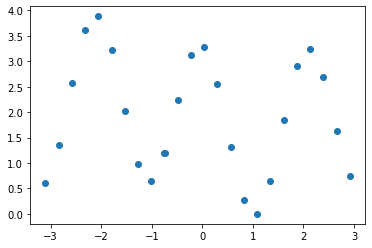

{-0.7523166780471802: (1.1892472746985732, nan),
 -0.49031667804718015: (2.241060656906484, nan),
 -0.22831667804718014: (3.131939229871932, nan),
 0.03368332195281987: (3.2826015718164854, nan),
 0.2956833219528199: (2.5509522000975267, nan),
 0.5576833219528199: (1.3190928974945564, nan),
 0.8196833219528199: (0.27240065274600056, nan),
 1.08168332195282: (0.0, nan),
 1.34368332195282: (0.6508407169421844, nan),
 1.60568332195282: (1.8470976362259535, nan),
 1.86768332195282: (2.9054958071974397, nan),
 2.12968332195282: (3.236918316237279, nan),
 2.39168332195282: (2.689829932212888, nan),
 2.65368332195282: (1.6362556443200447, nan),
 2.91568332195282: (0.7499981418077368, nan),
 -3.1055019852267662: (0.6076331823387591, nan),
 -2.8435019852267662: (1.3463342343384284, nan),
 -2.581501985226766: (2.5798103554734553, nan),
 -2.319501985226766: (3.6216007870934845, nan),
 -2.057501985226766: (3.885357915656641, nan),
 -1.7955019852267662: (3.2270552902045893, nan),
 -1.53350198522676

In [10]:
# SER->ALA -- SER at lambda = 0
run_torsion_scan(rhtf, 0, True, [6, 7, 10, 11], [6, 7, 10, 11], [14, 15, 16], repartitioned=True)

-10158.77365306802


100%|██████████| 10000/10000 [00:06<00:00, 1466.20it/s]


-1.3414593
-31084.091182826847


INFO:root:Rotating by -2.808409309536381 radians
INFO:root:Rotating by 0.26199999999999934 radians
INFO:root:Rotating by 0.26200000000000034 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999977 radians
INFO:root:Rotating by 0.2620000000000019 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.26200000000000034 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26199999999999934 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2620000000000011 radians
INFO:root:Rotating by 0.2619999999999991 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by -6.021185307179588 radians
INFO:root:Rotating by 0.2620000000000009 radians
INFO:root:Rotating by 0.2619999999999991 radians
INFO:root:Rotating by 0.2620000000000009 radians
INFO

-31084.091153316316
-31084.091171907352
-31084.09117771407
-31084.091176650698
-31084.091185087465
-31084.091154608188
-31084.091172076118
-31084.091172649627
-31084.09115531312
-31084.091150199387
-31084.09112968472
-31084.091117869673
-31084.091136245654
-31084.091124608327
-31084.09111672267
-31084.091120342902
-31084.09113117971
-31084.091149053875
-31084.091138717387
-31084.091124907027
-31084.091135994742
-31084.09117322313
-31084.091148156283
-31084.091164548903
raw d: {-1.0794592742919922: (-31084.091153316316, nan), -0.8174592742919922: (-31084.091171907352, nan), -0.5554592742919922: (-31084.09117771407, nan), -0.29345927429199214: (-31084.091176650698, nan), -0.031459274291992134: (-31084.091185087465, nan), 0.23054072570800788: (-31084.091154608188, nan), 0.4925407257080079: (-31084.091172076118, nan), 0.7545407257080079: (-31084.091172649627, nan), 1.016540725708008: (-31084.09115531312, nan), 1.278540725708008: (-31084.091150199387, nan), 1.540540725708008: (-31084.091129

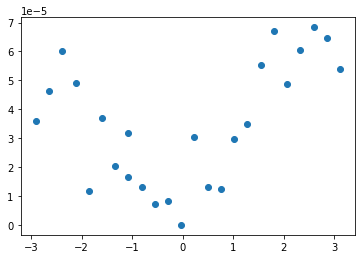

{-1.0794592742919922: (3.1771149224368855e-05, nan),
 -0.8174592742919922: (1.3180113455746323e-05, nan),
 -0.5554592742919922: (7.373393600573763e-06, nan),
 -0.29345927429199214: (8.436767529929057e-06, nan),
 -0.031459274291992134: (0.0, nan),
 0.23054072570800788: (3.047927748411894e-05, nan),
 0.4925407257080079: (1.3011347618885338e-05, nan),
 0.7545407257080079: (1.2437838449841365e-05, nan),
 1.016540725708008: (2.9774346330668777e-05, nan),
 1.278540725708008: (3.488807851681486e-05, nan),
 1.540540725708008: (5.540274651139043e-05, nan),
 1.802540725708008: (6.721779209328815e-05, nan),
 2.064540725708008: (4.884181180386804e-05, nan),
 2.326540725708008: (6.0479138483060524e-05, nan),
 2.588540725708008: (6.836479587946087e-05, nan),
 2.850540725708008: (6.474456313299015e-05, nan),
 3.112540725708008: (5.3907755500404164e-05, nan),
 -2.9086445814715782: (3.603359073167667e-05, nan),
 -2.646644581471578: (4.637007805285975e-05, nan),
 -2.384644581471578: (6.018043859512545e-

In [18]:
# SER->ALA -- ALA at lambda = 0
run_torsion_scan(rhtf, 0, False, [6, 7, 5575, 5578], [6, 7, 10, 15], [5576, 5577], repartitioned=True)


# 8-mer solvent r-htf lambda = 1

In [38]:
data_dir = "/data/chodera/zhangi/perses_benchmark/neq/10/15/"

with open(os.path.join(data_dir, f"15_solvent_1.pickle"), "rb") as f:
    rhtf = pickle.load(f)

In [39]:
rhtf

In [20]:
for atom in rhtf.hybrid_topology.atoms:
    print(atom, atom.index)

ACE0-CH3 0
ACE0-C 1
ACE0-O 2
ACE0-H1 3
ACE0-H2 4
ACE0-H3 5
SER1-N 6
SER1-CA 7
SER1-C 8
SER1-O 9
SER1-CB 10
SER1-OG 11
SER1-H 12
SER1-HA 13
SER1-HB3 14
SER1-HB2 15
SER1-HG 16
SER1-CB 5575
SER1-HB3 5576
SER1-HB2 5577
SER1-HB1 5578
ALA2-N 17
ALA2-CA 18
ALA2-C 19
ALA2-O 20
ALA2-CB 21
ALA2-H 22
ALA2-HA 23
ALA2-HB1 24
ALA2-HB2 25
ALA2-HB3 26
VAL3-N 27
VAL3-CA 28
VAL3-C 29
VAL3-O 30
VAL3-CB 31
VAL3-CG1 32
VAL3-CG2 33
VAL3-H 34
VAL3-HA 35
VAL3-HB 36
VAL3-HG11 37
VAL3-HG12 38
VAL3-HG13 39
VAL3-HG21 40
VAL3-HG22 41
VAL3-HG23 42
LEU4-N 43
LEU4-CA 44
LEU4-C 45
LEU4-O 46
LEU4-CB 47
LEU4-CG 48
LEU4-CD1 49
LEU4-CD2 50
LEU4-H 51
LEU4-HA 52
LEU4-HB3 53
LEU4-HB2 54
LEU4-HG 55
LEU4-HD11 56
LEU4-HD12 57
LEU4-HD13 58
LEU4-HD21 59
LEU4-HD22 60
LEU4-HD23 61
GLN5-N 62
GLN5-CA 63
GLN5-C 64
GLN5-O 65
GLN5-CB 66
GLN5-CG 67
GLN5-CD 68
GLN5-NE2 69
GLN5-OE1 70
GLN5-H 71
GLN5-HA 72
GLN5-HB3 73
GLN5-HB2 74
GLN5-HG3 75
GLN5-HG2 76
GLN5-HE22 77
GLN5-HE21 78
SER6-N 79
SER6-CA 80
SER6-C 81
SER6-O 82
SER6-CB 83
SER6-OG 84

HOH536-H1 1693
HOH536-H2 1694
HOH537-O 1695
HOH537-H1 1696
HOH537-H2 1697
HOH538-O 1698
HOH538-H1 1699
HOH538-H2 1700
HOH539-O 1701
HOH539-H1 1702
HOH539-H2 1703
HOH540-O 1704
HOH540-H1 1705
HOH540-H2 1706
HOH541-O 1707
HOH541-H1 1708
HOH541-H2 1709
HOH542-O 1710
HOH542-H1 1711
HOH542-H2 1712
HOH543-O 1713
HOH543-H1 1714
HOH543-H2 1715
HOH544-O 1716
HOH544-H1 1717
HOH544-H2 1718
HOH545-O 1719
HOH545-H1 1720
HOH545-H2 1721
HOH546-O 1722
HOH546-H1 1723
HOH546-H2 1724
HOH547-O 1725
HOH547-H1 1726
HOH547-H2 1727
HOH548-O 1728
HOH548-H1 1729
HOH548-H2 1730
HOH549-O 1731
HOH549-H1 1732
HOH549-H2 1733
HOH550-O 1734
HOH550-H1 1735
HOH550-H2 1736
HOH551-O 1737
HOH551-H1 1738
HOH551-H2 1739
HOH552-O 1740
HOH552-H1 1741
HOH552-H2 1742
HOH553-O 1743
HOH553-H1 1744
HOH553-H2 1745
HOH554-O 1746
HOH554-H1 1747
HOH554-H2 1748
HOH555-O 1749
HOH555-H1 1750
HOH555-H2 1751
HOH556-O 1752
HOH556-H1 1753
HOH556-H2 1754
HOH557-O 1755
HOH557-H1 1756
HOH557-H2 1757
HOH558-O 1758
HOH558-H1 1759
HOH558-H2 1760
HO

HOH1292-H1 3943
HOH1292-H2 3944
HOH1293-O 3945
HOH1293-H1 3946
HOH1293-H2 3947
HOH1294-O 3948
HOH1294-H1 3949
HOH1294-H2 3950
HOH1295-O 3951
HOH1295-H1 3952
HOH1295-H2 3953
HOH1296-O 3954
HOH1296-H1 3955
HOH1296-H2 3956
HOH1297-O 3957
HOH1297-H1 3958
HOH1297-H2 3959
HOH1298-O 3960
HOH1298-H1 3961
HOH1298-H2 3962
HOH1299-O 3963
HOH1299-H1 3964
HOH1299-H2 3965
HOH1300-O 3966
HOH1300-H1 3967
HOH1300-H2 3968
HOH1301-O 3969
HOH1301-H1 3970
HOH1301-H2 3971
HOH1302-O 3972
HOH1302-H1 3973
HOH1302-H2 3974
HOH1303-O 3975
HOH1303-H1 3976
HOH1303-H2 3977
HOH1304-O 3978
HOH1304-H1 3979
HOH1304-H2 3980
HOH1305-O 3981
HOH1305-H1 3982
HOH1305-H2 3983
HOH1306-O 3984
HOH1306-H1 3985
HOH1306-H2 3986
HOH1307-O 3987
HOH1307-H1 3988
HOH1307-H2 3989
HOH1308-O 3990
HOH1308-H1 3991
HOH1308-H2 3992
HOH1309-O 3993
HOH1309-H1 3994
HOH1309-H2 3995
HOH1310-O 3996
HOH1310-H1 3997
HOH1310-H2 3998
HOH1311-O 3999
HOH1311-H1 4000
HOH1311-H2 4001
HOH1312-O 4002
HOH1312-H1 4003
HOH1312-H2 4004
HOH1313-O 4005
HOH1313-H1 40

In [21]:
for atom in rhtf._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

<Atom 0 (CH3) of chain 0 residue 0 (ACE)> 0
<Atom 1 (C) of chain 0 residue 0 (ACE)> 1
<Atom 2 (O) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H1) of chain 0 residue 0 (ACE)> 3
<Atom 4 (H2) of chain 0 residue 0 (ACE)> 4
<Atom 5 (H3) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (SER)> 6
<Atom 7 (CA) of chain 0 residue 1 (SER)> 7
<Atom 8 (C) of chain 0 residue 1 (SER)> 8
<Atom 9 (O) of chain 0 residue 1 (SER)> 9
<Atom 10 (CB) of chain 0 residue 1 (SER)> 10
<Atom 11 (OG) of chain 0 residue 1 (SER)> 11
<Atom 12 (H) of chain 0 residue 1 (SER)> 12
<Atom 13 (HA) of chain 0 residue 1 (SER)> 13
<Atom 14 (HB3) of chain 0 residue 1 (SER)> 14
<Atom 15 (HB2) of chain 0 residue 1 (SER)> 15
<Atom 16 (HG) of chain 0 residue 1 (SER)> 16
<Atom 17 (N) of chain 0 residue 2 (ALA)> 17
<Atom 18 (CA) of chain 0 residue 2 (ALA)> 18
<Atom 19 (C) of chain 0 residue 2 (ALA)> 19
<Atom 20 (O) of chain 0 residue 2 (ALA)> 20
<Atom 21 (CB) of chain 0 residue 2 (ALA)> 21
<Atom 22 (H) of chain 0 residue 2 (A

<Atom 1614 (O) of chain 1 residue 507 (HOH)> 1614
<Atom 1615 (H1) of chain 1 residue 507 (HOH)> 1615
<Atom 1616 (H2) of chain 1 residue 507 (HOH)> 1616
<Atom 1617 (O) of chain 1 residue 508 (HOH)> 1617
<Atom 1618 (H1) of chain 1 residue 508 (HOH)> 1618
<Atom 1619 (H2) of chain 1 residue 508 (HOH)> 1619
<Atom 1620 (O) of chain 1 residue 509 (HOH)> 1620
<Atom 1621 (H1) of chain 1 residue 509 (HOH)> 1621
<Atom 1622 (H2) of chain 1 residue 509 (HOH)> 1622
<Atom 1623 (O) of chain 1 residue 510 (HOH)> 1623
<Atom 1624 (H1) of chain 1 residue 510 (HOH)> 1624
<Atom 1625 (H2) of chain 1 residue 510 (HOH)> 1625
<Atom 1626 (O) of chain 1 residue 511 (HOH)> 1626
<Atom 1627 (H1) of chain 1 residue 511 (HOH)> 1627
<Atom 1628 (H2) of chain 1 residue 511 (HOH)> 1628
<Atom 1629 (O) of chain 1 residue 512 (HOH)> 1629
<Atom 1630 (H1) of chain 1 residue 512 (HOH)> 1630
<Atom 1631 (H2) of chain 1 residue 512 (HOH)> 1631
<Atom 1632 (O) of chain 1 residue 513 (HOH)> 1632
<Atom 1633 (H1) of chain 1 residue 513

<Atom 3364 (H1) of chain 1 residue 1090 (HOH)> 3364
<Atom 3365 (H2) of chain 1 residue 1090 (HOH)> 3365
<Atom 3366 (O) of chain 1 residue 1091 (HOH)> 3366
<Atom 3367 (H1) of chain 1 residue 1091 (HOH)> 3367
<Atom 3368 (H2) of chain 1 residue 1091 (HOH)> 3368
<Atom 3369 (O) of chain 1 residue 1092 (HOH)> 3369
<Atom 3370 (H1) of chain 1 residue 1092 (HOH)> 3370
<Atom 3371 (H2) of chain 1 residue 1092 (HOH)> 3371
<Atom 3372 (O) of chain 1 residue 1093 (HOH)> 3372
<Atom 3373 (H1) of chain 1 residue 1093 (HOH)> 3373
<Atom 3374 (H2) of chain 1 residue 1093 (HOH)> 3374
<Atom 3375 (O) of chain 1 residue 1094 (HOH)> 3375
<Atom 3376 (H1) of chain 1 residue 1094 (HOH)> 3376
<Atom 3377 (H2) of chain 1 residue 1094 (HOH)> 3377
<Atom 3378 (O) of chain 1 residue 1095 (HOH)> 3378
<Atom 3379 (H1) of chain 1 residue 1095 (HOH)> 3379
<Atom 3380 (H2) of chain 1 residue 1095 (HOH)> 3380
<Atom 3381 (O) of chain 1 residue 1096 (HOH)> 3381
<Atom 3382 (H1) of chain 1 residue 1096 (HOH)> 3382
<Atom 3383 (H2) of

<Atom 5114 (H2) of chain 1 residue 1673 (HOH)> 5114
<Atom 5115 (O) of chain 1 residue 1674 (HOH)> 5115
<Atom 5116 (H1) of chain 1 residue 1674 (HOH)> 5116
<Atom 5117 (H2) of chain 1 residue 1674 (HOH)> 5117
<Atom 5118 (O) of chain 1 residue 1675 (HOH)> 5118
<Atom 5119 (H1) of chain 1 residue 1675 (HOH)> 5119
<Atom 5120 (H2) of chain 1 residue 1675 (HOH)> 5120
<Atom 5121 (O) of chain 1 residue 1676 (HOH)> 5121
<Atom 5122 (H1) of chain 1 residue 1676 (HOH)> 5122
<Atom 5123 (H2) of chain 1 residue 1676 (HOH)> 5123
<Atom 5124 (O) of chain 1 residue 1677 (HOH)> 5124
<Atom 5125 (H1) of chain 1 residue 1677 (HOH)> 5125
<Atom 5126 (H2) of chain 1 residue 1677 (HOH)> 5126
<Atom 5127 (O) of chain 1 residue 1678 (HOH)> 5127
<Atom 5128 (H1) of chain 1 residue 1678 (HOH)> 5128
<Atom 5129 (H2) of chain 1 residue 1678 (HOH)> 5129
<Atom 5130 (O) of chain 1 residue 1679 (HOH)> 5130
<Atom 5131 (H1) of chain 1 residue 1679 (HOH)> 5131
<Atom 5132 (H2) of chain 1 residue 1679 (HOH)> 5132
<Atom 5133 (O) of 

In [22]:
for atom in rhtf._topology_proposal.new_topology.atoms():
    print(atom, atom.index)

<Atom 0 (CH3) of chain 0 residue 0 (ACE)> 0
<Atom 1 (C) of chain 0 residue 0 (ACE)> 1
<Atom 2 (O) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H1) of chain 0 residue 0 (ACE)> 3
<Atom 4 (H2) of chain 0 residue 0 (ACE)> 4
<Atom 5 (H3) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (ALA)> 6
<Atom 7 (CA) of chain 0 residue 1 (ALA)> 7
<Atom 8 (C) of chain 0 residue 1 (ALA)> 8
<Atom 9 (O) of chain 0 residue 1 (ALA)> 9
<Atom 10 (CB) of chain 0 residue 1 (ALA)> 10
<Atom 11 (H) of chain 0 residue 1 (ALA)> 11
<Atom 12 (HA) of chain 0 residue 1 (ALA)> 12
<Atom 13 (HB3) of chain 0 residue 1 (ALA)> 13
<Atom 14 (HB2) of chain 0 residue 1 (ALA)> 14
<Atom 15 (HB1) of chain 0 residue 1 (ALA)> 15
<Atom 16 (N) of chain 0 residue 2 (ALA)> 16
<Atom 17 (CA) of chain 0 residue 2 (ALA)> 17
<Atom 18 (C) of chain 0 residue 2 (ALA)> 18
<Atom 19 (O) of chain 0 residue 2 (ALA)> 19
<Atom 20 (CB) of chain 0 residue 2 (ALA)> 20
<Atom 21 (H) of chain 0 residue 2 (ALA)> 21
<Atom 22 (HA) of chain 0 residue 2 (

<Atom 1536 (H1) of chain 1 residue 481 (HOH)> 1536
<Atom 1537 (H2) of chain 1 residue 481 (HOH)> 1537
<Atom 1538 (O) of chain 1 residue 482 (HOH)> 1538
<Atom 1539 (H1) of chain 1 residue 482 (HOH)> 1539
<Atom 1540 (H2) of chain 1 residue 482 (HOH)> 1540
<Atom 1541 (O) of chain 1 residue 483 (HOH)> 1541
<Atom 1542 (H1) of chain 1 residue 483 (HOH)> 1542
<Atom 1543 (H2) of chain 1 residue 483 (HOH)> 1543
<Atom 1544 (O) of chain 1 residue 484 (HOH)> 1544
<Atom 1545 (H1) of chain 1 residue 484 (HOH)> 1545
<Atom 1546 (H2) of chain 1 residue 484 (HOH)> 1546
<Atom 1547 (O) of chain 1 residue 485 (HOH)> 1547
<Atom 1548 (H1) of chain 1 residue 485 (HOH)> 1548
<Atom 1549 (H2) of chain 1 residue 485 (HOH)> 1549
<Atom 1550 (O) of chain 1 residue 486 (HOH)> 1550
<Atom 1551 (H1) of chain 1 residue 486 (HOH)> 1551
<Atom 1552 (H2) of chain 1 residue 486 (HOH)> 1552
<Atom 1553 (O) of chain 1 residue 487 (HOH)> 1553
<Atom 1554 (H1) of chain 1 residue 487 (HOH)> 1554
<Atom 1555 (H2) of chain 1 residue 48

<Atom 3285 (H1) of chain 1 residue 1064 (HOH)> 3285
<Atom 3286 (H2) of chain 1 residue 1064 (HOH)> 3286
<Atom 3287 (O) of chain 1 residue 1065 (HOH)> 3287
<Atom 3288 (H1) of chain 1 residue 1065 (HOH)> 3288
<Atom 3289 (H2) of chain 1 residue 1065 (HOH)> 3289
<Atom 3290 (O) of chain 1 residue 1066 (HOH)> 3290
<Atom 3291 (H1) of chain 1 residue 1066 (HOH)> 3291
<Atom 3292 (H2) of chain 1 residue 1066 (HOH)> 3292
<Atom 3293 (O) of chain 1 residue 1067 (HOH)> 3293
<Atom 3294 (H1) of chain 1 residue 1067 (HOH)> 3294
<Atom 3295 (H2) of chain 1 residue 1067 (HOH)> 3295
<Atom 3296 (O) of chain 1 residue 1068 (HOH)> 3296
<Atom 3297 (H1) of chain 1 residue 1068 (HOH)> 3297
<Atom 3298 (H2) of chain 1 residue 1068 (HOH)> 3298
<Atom 3299 (O) of chain 1 residue 1069 (HOH)> 3299
<Atom 3300 (H1) of chain 1 residue 1069 (HOH)> 3300
<Atom 3301 (H2) of chain 1 residue 1069 (HOH)> 3301
<Atom 3302 (O) of chain 1 residue 1070 (HOH)> 3302
<Atom 3303 (H1) of chain 1 residue 1070 (HOH)> 3303
<Atom 3304 (H2) of

<Atom 5035 (H2) of chain 1 residue 1647 (HOH)> 5035
<Atom 5036 (O) of chain 1 residue 1648 (HOH)> 5036
<Atom 5037 (H1) of chain 1 residue 1648 (HOH)> 5037
<Atom 5038 (H2) of chain 1 residue 1648 (HOH)> 5038
<Atom 5039 (O) of chain 1 residue 1649 (HOH)> 5039
<Atom 5040 (H1) of chain 1 residue 1649 (HOH)> 5040
<Atom 5041 (H2) of chain 1 residue 1649 (HOH)> 5041
<Atom 5042 (O) of chain 1 residue 1650 (HOH)> 5042
<Atom 5043 (H1) of chain 1 residue 1650 (HOH)> 5043
<Atom 5044 (H2) of chain 1 residue 1650 (HOH)> 5044
<Atom 5045 (O) of chain 1 residue 1651 (HOH)> 5045
<Atom 5046 (H1) of chain 1 residue 1651 (HOH)> 5046
<Atom 5047 (H2) of chain 1 residue 1651 (HOH)> 5047
<Atom 5048 (O) of chain 1 residue 1652 (HOH)> 5048
<Atom 5049 (H1) of chain 1 residue 1652 (HOH)> 5049
<Atom 5050 (H2) of chain 1 residue 1652 (HOH)> 5050
<Atom 5051 (O) of chain 1 residue 1653 (HOH)> 5051
<Atom 5052 (H1) of chain 1 residue 1653 (HOH)> 5052
<Atom 5053 (H2) of chain 1 residue 1653 (HOH)> 5053
<Atom 5054 (O) of 

27205.45887759746


100%|██████████| 10000/10000 [00:06<00:00, 1472.63it/s]


-1.0143167
-30691.127328874732


INFO:root:Rotating by -2.679023187632846 radians
INFO:root:Rotating by 0.2620000000000001 radians
INFO:root:Rotating by 0.26199999999999996 radians
INFO:root:Rotating by 0.2620000000000001 radians
INFO:root:Rotating by 0.2619999999999984 radians
INFO:root:Rotating by 0.26200000000000107 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by -6.021185307179587 radians
INFO:root:Rotating by 0.2619999999999987 radians
INFO:root:Rotating by 0.26200000000000134 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000045 radian

-30691.127210360566
-30691.127210458762
-30691.127193521766
-30691.127197238704
-30691.127197862617
-30691.127202304644
-30691.127203935168
-30691.127205168796
-30691.127199954633
-30691.127214850763
-30691.127203917993
-30691.127186044203
-30691.12720908176
-30691.127190399242
-30691.127200504234
-30691.12717955235
-30691.12719432676
-30691.1272165765
-30691.127193015098
-30691.127203222026
-30691.127191276293
-30691.127200556883
-30691.127195009285
-30691.1272067071
raw d: {-0.7523166780471802: (-30691.127210360566, nan), -0.49031667804718015: (-30691.127210458762, nan), -0.22831667804718014: (-30691.127193521766, nan), 0.03368332195281987: (-30691.127197238704, nan), 0.2956833219528199: (-30691.127197862617, nan), 0.5576833219528199: (-30691.127202304644, nan), 0.8196833219528199: (-30691.127203935168, nan), 1.08168332195282: (-30691.127205168796, nan), 1.34368332195282: (-30691.127199954633, nan), 1.60568332195282: (-30691.127214850763, nan), 1.86768332195282: (-30691.127203917993,

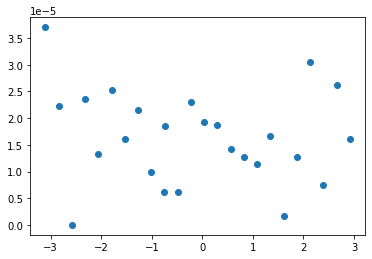

{-0.7523166780471802: (6.215934263309464e-06, nan),
 -0.49031667804718015: (6.117737939348444e-06, nan),
 -0.22831667804718014: (2.3054733901517466e-05, nan),
 0.03368332195281987: (1.9337796402396634e-05, nan),
 0.2956833219528199: (1.8713883036980405e-05, nan),
 0.5576833219528199: (1.4271856343839318e-05, nan),
 0.8196833219528199: (1.2641332432394847e-05, nan),
 1.08168332195282: (1.1407704732846469e-05, nan),
 1.34368332195282: (1.6621866961941123e-05, nan),
 1.60568332195282: (1.7257370927836746e-06, nan),
 1.86768332195282: (1.2658507330343127e-05, nan),
 2.12968332195282: (3.053229738725349e-05, nan),
 2.39168332195282: (7.4947420216631144e-06, nan),
 2.65368332195282: (2.6177258405368775e-05, nan),
 2.91568332195282: (1.6072266589617357e-05, nan),
 -3.1055019852267662: (3.702415051520802e-05, nan),
 -2.8435019852267662: (2.2249740140978247e-05, nan),
 -2.581501985226766: (0.0, nan),
 -2.319501985226766: (2.3561402485938743e-05, nan),
 -2.057501985226766: (1.3354474504012614e-0

In [23]:
# SER->ALA -- SER at lambda = 1
run_torsion_scan(rhtf, 1, True, [6, 7, 10, 11], [6, 7, 10, 11], [14, 15, 16], repartitioned=True)

# Generate torsion scans for the r-htf: THR->ALA lambda = 0

In [36]:
data_dir = "/data/chodera/zhangi/perses_benchmark/neq/10/14/"

with open(os.path.join(data_dir, f"14_solvent_0.pickle"), "rb") as f:
    rhtf = pickle.load(f)

In [37]:
rhtf

#### Look at hybrid topology to determine indices

In [8]:
for atom in rhtf.hybrid_topology.atoms:
    print(atom, atom.index)

ACE1-C 0
ACE1-O 1
ACE1-CH3 2
ACE1-H1 3
ACE1-H2 4
ACE1-H3 5
THR2-N 6
THR2-CA 7
THR2-C 8
THR2-O 9
THR2-CB 10
THR2-CG2 11
THR2-OG1 12
THR2-H 13
THR2-HA 14
THR2-HB 15
THR2-HG1 16
THR2-HG21 17
THR2-HG22 18
THR2-HG23 19
THR2-CB 1549
THR2-HB1 1550
THR2-HB2 1551
THR2-HB3 1552
NME3-N 20
NME3-C 21
NME3-H 22
NME3-H1 23
NME3-H2 24
NME3-H3 25
HOH4-O 26
HOH4-H1 27
HOH4-H2 28
HOH5-O 29
HOH5-H1 30
HOH5-H2 31
HOH6-O 32
HOH6-H1 33
HOH6-H2 34
HOH7-O 35
HOH7-H1 36
HOH7-H2 37
HOH8-O 38
HOH8-H1 39
HOH8-H2 40
HOH9-O 41
HOH9-H1 42
HOH9-H2 43
HOH10-O 44
HOH10-H1 45
HOH10-H2 46
HOH11-O 47
HOH11-H1 48
HOH11-H2 49
HOH12-O 50
HOH12-H1 51
HOH12-H2 52
HOH13-O 53
HOH13-H1 54
HOH13-H2 55
HOH14-O 56
HOH14-H1 57
HOH14-H2 58
HOH15-O 59
HOH15-H1 60
HOH15-H2 61
HOH16-O 62
HOH16-H1 63
HOH16-H2 64
HOH17-O 65
HOH17-H1 66
HOH17-H2 67
HOH18-O 68
HOH18-H1 69
HOH18-H2 70
HOH19-O 71
HOH19-H1 72
HOH19-H2 73
HOH20-O 74
HOH20-H1 75
HOH20-H2 76
HOH21-O 77
HOH21-H1 78
HOH21-H2 79
HOH22-O 80
HOH22-H1 81
HOH22-H2 82
HOH23-O 83
HOH23-H1 8

HOH230-O 704
HOH230-H1 705
HOH230-H2 706
HOH231-O 707
HOH231-H1 708
HOH231-H2 709
HOH232-O 710
HOH232-H1 711
HOH232-H2 712
HOH233-O 713
HOH233-H1 714
HOH233-H2 715
HOH234-O 716
HOH234-H1 717
HOH234-H2 718
HOH235-O 719
HOH235-H1 720
HOH235-H2 721
HOH236-O 722
HOH236-H1 723
HOH236-H2 724
HOH237-O 725
HOH237-H1 726
HOH237-H2 727
HOH238-O 728
HOH238-H1 729
HOH238-H2 730
HOH239-O 731
HOH239-H1 732
HOH239-H2 733
HOH240-O 734
HOH240-H1 735
HOH240-H2 736
HOH241-O 737
HOH241-H1 738
HOH241-H2 739
HOH242-O 740
HOH242-H1 741
HOH242-H2 742
HOH243-O 743
HOH243-H1 744
HOH243-H2 745
HOH244-O 746
HOH244-H1 747
HOH244-H2 748
HOH245-O 749
HOH245-H1 750
HOH245-H2 751
HOH246-O 752
HOH246-H1 753
HOH246-H2 754
HOH247-O 755
HOH247-H1 756
HOH247-H2 757
HOH248-O 758
HOH248-H1 759
HOH248-H2 760
HOH249-O 761
HOH249-H1 762
HOH249-H2 763
HOH250-O 764
HOH250-H1 765
HOH250-H2 766
HOH251-O 767
HOH251-H1 768
HOH251-H2 769
HOH252-O 770
HOH252-H1 771
HOH252-H2 772
HOH253-O 773
HOH253-H1 774
HOH253-H2 775
HOH254-O 776
HOH

In [9]:
for atom in rhtf._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

<Atom 0 (C) of chain 0 residue 0 (ACE)> 0
<Atom 1 (O) of chain 0 residue 0 (ACE)> 1
<Atom 2 (CH3) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H1) of chain 0 residue 0 (ACE)> 3
<Atom 4 (H2) of chain 0 residue 0 (ACE)> 4
<Atom 5 (H3) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (THR)> 6
<Atom 7 (CA) of chain 0 residue 1 (THR)> 7
<Atom 8 (C) of chain 0 residue 1 (THR)> 8
<Atom 9 (O) of chain 0 residue 1 (THR)> 9
<Atom 10 (CB) of chain 0 residue 1 (THR)> 10
<Atom 11 (CG2) of chain 0 residue 1 (THR)> 11
<Atom 12 (OG1) of chain 0 residue 1 (THR)> 12
<Atom 13 (H) of chain 0 residue 1 (THR)> 13
<Atom 14 (HA) of chain 0 residue 1 (THR)> 14
<Atom 15 (HB) of chain 0 residue 1 (THR)> 15
<Atom 16 (HG1) of chain 0 residue 1 (THR)> 16
<Atom 17 (HG21) of chain 0 residue 1 (THR)> 17
<Atom 18 (HG22) of chain 0 residue 1 (THR)> 18
<Atom 19 (HG23) of chain 0 residue 1 (THR)> 19
<Atom 20 (N) of chain 0 residue 2 (NME)> 20
<Atom 21 (C) of chain 0 residue 2 (NME)> 21
<Atom 22 (H) of chain 0 resi

<Atom 1402 (H2) of chain 1 residue 461 (HOH)> 1402
<Atom 1403 (O) of chain 1 residue 462 (HOH)> 1403
<Atom 1404 (H1) of chain 1 residue 462 (HOH)> 1404
<Atom 1405 (H2) of chain 1 residue 462 (HOH)> 1405
<Atom 1406 (O) of chain 1 residue 463 (HOH)> 1406
<Atom 1407 (H1) of chain 1 residue 463 (HOH)> 1407
<Atom 1408 (H2) of chain 1 residue 463 (HOH)> 1408
<Atom 1409 (O) of chain 1 residue 464 (HOH)> 1409
<Atom 1410 (H1) of chain 1 residue 464 (HOH)> 1410
<Atom 1411 (H2) of chain 1 residue 464 (HOH)> 1411
<Atom 1412 (O) of chain 1 residue 465 (HOH)> 1412
<Atom 1413 (H1) of chain 1 residue 465 (HOH)> 1413
<Atom 1414 (H2) of chain 1 residue 465 (HOH)> 1414
<Atom 1415 (O) of chain 1 residue 466 (HOH)> 1415
<Atom 1416 (H1) of chain 1 residue 466 (HOH)> 1416
<Atom 1417 (H2) of chain 1 residue 466 (HOH)> 1417
<Atom 1418 (O) of chain 1 residue 467 (HOH)> 1418
<Atom 1419 (H1) of chain 1 residue 467 (HOH)> 1419
<Atom 1420 (H2) of chain 1 residue 467 (HOH)> 1420
<Atom 1421 (O) of chain 1 residue 468

In [10]:
for atom in rhtf._topology_proposal.new_topology.atoms():
    print(atom, atom.index)

<Atom 0 (C) of chain 0 residue 0 (ACE)> 0
<Atom 1 (O) of chain 0 residue 0 (ACE)> 1
<Atom 2 (CH3) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H1) of chain 0 residue 0 (ACE)> 3
<Atom 4 (H2) of chain 0 residue 0 (ACE)> 4
<Atom 5 (H3) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (ALA)> 6
<Atom 7 (CA) of chain 0 residue 1 (ALA)> 7
<Atom 8 (C) of chain 0 residue 1 (ALA)> 8
<Atom 9 (O) of chain 0 residue 1 (ALA)> 9
<Atom 10 (CB) of chain 0 residue 1 (ALA)> 10
<Atom 11 (H) of chain 0 residue 1 (ALA)> 11
<Atom 12 (HA) of chain 0 residue 1 (ALA)> 12
<Atom 13 (HB1) of chain 0 residue 1 (ALA)> 13
<Atom 14 (HB2) of chain 0 residue 1 (ALA)> 14
<Atom 15 (HB3) of chain 0 residue 1 (ALA)> 15
<Atom 16 (N) of chain 0 residue 2 (NME)> 16
<Atom 17 (C) of chain 0 residue 2 (NME)> 17
<Atom 18 (H) of chain 0 residue 2 (NME)> 18
<Atom 19 (H1) of chain 0 residue 2 (NME)> 19
<Atom 20 (H2) of chain 0 residue 2 (NME)> 20
<Atom 21 (H3) of chain 0 residue 2 (NME)> 21
<Atom 22 (O) of chain 1 residue 3 (

<Atom 1349 (H1) of chain 1 residue 445 (HOH)> 1349
<Atom 1350 (H2) of chain 1 residue 445 (HOH)> 1350
<Atom 1351 (O) of chain 1 residue 446 (HOH)> 1351
<Atom 1352 (H1) of chain 1 residue 446 (HOH)> 1352
<Atom 1353 (H2) of chain 1 residue 446 (HOH)> 1353
<Atom 1354 (O) of chain 1 residue 447 (HOH)> 1354
<Atom 1355 (H1) of chain 1 residue 447 (HOH)> 1355
<Atom 1356 (H2) of chain 1 residue 447 (HOH)> 1356
<Atom 1357 (O) of chain 1 residue 448 (HOH)> 1357
<Atom 1358 (H1) of chain 1 residue 448 (HOH)> 1358
<Atom 1359 (H2) of chain 1 residue 448 (HOH)> 1359
<Atom 1360 (O) of chain 1 residue 449 (HOH)> 1360
<Atom 1361 (H1) of chain 1 residue 449 (HOH)> 1361
<Atom 1362 (H2) of chain 1 residue 449 (HOH)> 1362
<Atom 1363 (O) of chain 1 residue 450 (HOH)> 1363
<Atom 1364 (H1) of chain 1 residue 450 (HOH)> 1364
<Atom 1365 (H2) of chain 1 residue 450 (HOH)> 1365
<Atom 1366 (O) of chain 1 residue 451 (HOH)> 1366
<Atom 1367 (H1) of chain 1 residue 451 (HOH)> 1367
<Atom 1368 (H2) of chain 1 residue 45

7.799503301870468


100%|██████████| 10000/10000 [00:04<00:00, 2480.66it/s]
INFO:root:Rotating by 1.300072059353861 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.2620000000000001 radians
INFO:root:Rotating by 0.2620000000000005 radians
INFO:root:Rotating by 0.2620000000000189 radians
INFO:root:Rotating by 0.26199999999997986 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by -6.021185307179586 radians
INFO:root:Rotating by 0.2619999999999787 radians
INFO:root:Rotating by 0.26200000000002044 radians
INFO:root:Rotating by 0.2620000000000009 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262000000000000

-1.0492564
-8581.618207646376
-8581.618143127016
-8581.618133592534
-8581.618135599792
-8581.61813503376
-8581.618143830454
-8581.618144626487
-8581.618140162425
-8581.618146349982
-8581.61813927081
-8581.61814819893
-8581.618134321361
-8581.61813662284
-8581.618145761544
-8581.618140601513
-8581.618140490995
-8581.618143009031
-8581.618147023548
-8581.618150336122
-8581.618138392632
-8581.618147608999
-8581.61813915581
-8581.618134539412
-8581.618139880155
-8581.618143885713
raw d: {-0.787256443977356: (-8581.618143127016, nan), -0.5252564439773559: (-8581.618133592534, nan), -0.2632564439773559: (-8581.618135599792, nan), -0.0012564439773559144: (-8581.61813503376, nan), 0.2607435560226441: (-8581.618143830454, nan), 0.5227435560226441: (-8581.618144626487, nan), 0.7847435560226441: (-8581.618140162425, nan), 1.0467435560226441: (-8581.618146349982, nan), 1.3087435560226441: (-8581.61813927081, nan), 1.5707435560226441: (-8581.61814819893, nan), 1.8327435560226442: (-8581.61813432136

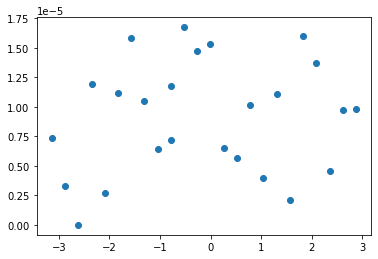

{-0.787256443977356: (7.209106115624309e-06, nan),
 -0.5252564439773559: (1.67435882758582e-05, nan),
 -0.2632564439773559: (1.4736329831066541e-05, nan),
 -0.0012564439773559144: (1.530236295366194e-05, nan),
 0.2607435560226441: (6.5056683524744585e-06, nan),
 0.5227435560226441: (5.709634933737107e-06, nan),
 0.7847435560226441: (1.0173696864512749e-05, nan),
 1.0467435560226441: (3.986140654888004e-06, nan),
 1.3087435560226441: (1.1065312719438225e-05, nan),
 1.5707435560226441: (2.1371924958657473e-06, nan),
 1.8327435560226442: (1.6014761058613658e-05, nan),
 2.094743556022644: (1.371328289678786e-05, nan),
 2.356743556022644: (4.574578269966878e-06, nan),
 2.618743556022644: (9.734609193401411e-06, nan),
 2.880743556022644: (9.84512735158205e-06, nan),
 -3.140441751156942: (7.3270912253065035e-06, nan),
 -2.878441751156942: (3.312574335723184e-06, nan),
 -2.616441751156942: (0.0, nan),
 -2.354441751156942: (1.1943489880650304e-05, nan),
 -2.092441751156942: (2.7271235012449324e

In [18]:
# THR->ALA -- ALA at lambda = 0
run_torsion_scan(rhtf, 0, False, [6, 7, 1549, 1550], [6, 7, 10, 13], [1551, 1552], repartitioned=True)

# Generate torsion scans for the r-htf: THR->ALA lambda = 1

In [34]:
data_dir = "/data/chodera/zhangi/perses_benchmark/neq/10/14/"

with open(os.path.join(data_dir, f"14_solvent_1.pickle"), "rb") as f:
    rhtf = pickle.load(f)

In [35]:
rhtf

-155.5634325572111


100%|██████████| 10000/10000 [00:03<00:00, 2502.39it/s]


3.0071301
-8559.358919222219


INFO:root:Rotating by -0.005659610574259677 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.2620000000000009 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26200000000000134 radians
INFO:root:Rotating by 0.26200000000000156 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262000000000002 radians
INFO:root:Rotating by 0.26199999999999934 radians
INFO:root:Rotating by 0.262000000000001 radians
INFO:root:Rotating by 0.26199999999999934 radians
INFO:root:Rotating by 0.2619999999999992 radians
INFO:root:Rotating by 0.2619999999999997 radians
INFO:root:Rotating by 0.26200000000000007 radians
INFO:root:Rotating by 0.261999999999999 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.2620000000000007 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.2619999999999991 radians
INFO:root:Rotating by 0.

-8559.406864857703
-8555.0685711638
-8548.012917308954
-8541.547736184648
-8538.493247995571
-8538.496097292722
-8538.588655799027
-8536.362689804688
-8531.36482655924
-8524.650576139864
-8518.21783249886
-8514.458678654793
-8515.03786267569
-8519.704056070557
-8526.529388846393
-8533.28775034167
-8538.313131976829
-8540.613875020605
-8540.09701936736
-8538.44451090124
-8539.38577487316
-8545.325761671578
-8553.519218994154
-8559.013927837834
raw d: {-3.014055161152975: (-8559.406864857703, nan), -2.752055161152975: (-8555.0685711638, nan), -2.490055161152975: (-8548.012917308954, nan), -2.228055161152975: (-8541.547736184648, nan), -1.9660551611529749: (-8538.493247995571, nan), -1.7040551611529748: (-8538.496097292722, nan), -1.4420551611529748: (-8538.588655799027, nan), -1.1800551611529748: (-8536.362689804688, nan), -0.9180551611529748: (-8531.36482655924, nan), -0.6560551611529748: (-8524.650576139864, nan), -0.3940551611529748: (-8518.21783249886, nan), -0.13205516115297478: (-8

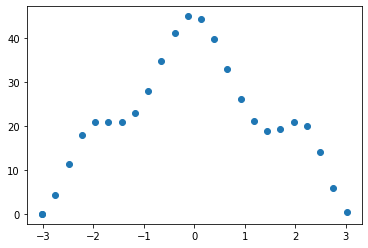

{-3.014055161152975: (0.0, nan),
 -2.752055161152975: (4.338293693903324, nan),
 -2.490055161152975: (11.393947548749566, nan),
 -2.228055161152975: (17.85912867305524, nan),
 -1.9660551611529749: (20.913616862131676, nan),
 -1.7040551611529748: (20.910767564981143, nan),
 -1.4420551611529748: (20.818209058676075, nan),
 -1.1800551611529748: (23.04417505301535, nan),
 -0.9180551611529748: (28.042038298463012, nan),
 -0.6560551611529748: (34.7562887178392, nan),
 -0.3940551611529748: (41.18903235884318, nan),
 -0.13205516115297478: (44.94818620290971, nan),
 0.12994483884702523: (44.36900218201299, nan),
 0.39194483884702525: (39.70280878714584, nan),
 0.6539448388470253: (32.87747601131014, nan),
 0.9159448388470253: (26.119114516033733, nan),
 1.1779448388470253: (21.093732880874086, nan),
 1.4399448388470253: (18.792989837098503, nan),
 1.7019448388470253: (19.309845490342923, nan),
 1.9639448388470253: (20.96235395646363, nan),
 2.2259448388470253: (20.021089984542414, nan),
 2.4879

In [20]:
# THR->ALA -- THR at lambda = 1
run_torsion_scan(rhtf, 1, True, [6, 7, 10, 12], [6, 7, 10, 12], [11, 15, 16, 17, 18, 19], repartitioned=True)

# Generate torsion scans for the flattened r-htf: THR->ALA lambda = 0

In [30]:
data_dir = "/data/chodera/zhangi/perses_benchmark/neq/10/13/"

with open(os.path.join(data_dir, f"13_solvent_0.pickle"), "rb") as f:
    rhtf = pickle.load(f)

In [31]:
rhtf

#### Look at hybrid topology to determine indices

In [23]:
for atom in rhtf.hybrid_topology.atoms:
    print(atom, atom.index)

ACE1-C 0
ACE1-O 1
ACE1-CH3 2
ACE1-H1 3
ACE1-H2 4
ACE1-H3 5
THR2-N 6
THR2-CA 7
THR2-C 8
THR2-O 9
THR2-CB 10
THR2-CG2 11
THR2-OG1 12
THR2-H 13
THR2-HA 14
THR2-HB 15
THR2-HG1 16
THR2-HG21 17
THR2-HG22 18
THR2-HG23 19
THR2-CB 1549
THR2-HB1 1550
THR2-HB2 1551
THR2-HB3 1552
NME3-N 20
NME3-C 21
NME3-H 22
NME3-H1 23
NME3-H2 24
NME3-H3 25
HOH4-O 26
HOH4-H1 27
HOH4-H2 28
HOH5-O 29
HOH5-H1 30
HOH5-H2 31
HOH6-O 32
HOH6-H1 33
HOH6-H2 34
HOH7-O 35
HOH7-H1 36
HOH7-H2 37
HOH8-O 38
HOH8-H1 39
HOH8-H2 40
HOH9-O 41
HOH9-H1 42
HOH9-H2 43
HOH10-O 44
HOH10-H1 45
HOH10-H2 46
HOH11-O 47
HOH11-H1 48
HOH11-H2 49
HOH12-O 50
HOH12-H1 51
HOH12-H2 52
HOH13-O 53
HOH13-H1 54
HOH13-H2 55
HOH14-O 56
HOH14-H1 57
HOH14-H2 58
HOH15-O 59
HOH15-H1 60
HOH15-H2 61
HOH16-O 62
HOH16-H1 63
HOH16-H2 64
HOH17-O 65
HOH17-H1 66
HOH17-H2 67
HOH18-O 68
HOH18-H1 69
HOH18-H2 70
HOH19-O 71
HOH19-H1 72
HOH19-H2 73
HOH20-O 74
HOH20-H1 75
HOH20-H2 76
HOH21-O 77
HOH21-H1 78
HOH21-H2 79
HOH22-O 80
HOH22-H1 81
HOH22-H2 82
HOH23-O 83
HOH23-H1 8

HOH412-O 1247
HOH412-H1 1248
HOH412-H2 1249
HOH413-O 1250
HOH413-H1 1251
HOH413-H2 1252
HOH414-O 1253
HOH414-H1 1254
HOH414-H2 1255
HOH415-O 1256
HOH415-H1 1257
HOH415-H2 1258
HOH416-O 1259
HOH416-H1 1260
HOH416-H2 1261
HOH417-O 1262
HOH417-H1 1263
HOH417-H2 1264
HOH418-O 1265
HOH418-H1 1266
HOH418-H2 1267
HOH419-O 1268
HOH419-H1 1269
HOH419-H2 1270
HOH420-O 1271
HOH420-H1 1272
HOH420-H2 1273
HOH421-O 1274
HOH421-H1 1275
HOH421-H2 1276
HOH422-O 1277
HOH422-H1 1278
HOH422-H2 1279
HOH423-O 1280
HOH423-H1 1281
HOH423-H2 1282
HOH424-O 1283
HOH424-H1 1284
HOH424-H2 1285
HOH425-O 1286
HOH425-H1 1287
HOH425-H2 1288
HOH426-O 1289
HOH426-H1 1290
HOH426-H2 1291
HOH427-O 1292
HOH427-H1 1293
HOH427-H2 1294
HOH428-O 1295
HOH428-H1 1296
HOH428-H2 1297
HOH429-O 1298
HOH429-H1 1299
HOH429-H2 1300
HOH430-O 1301
HOH430-H1 1302
HOH430-H2 1303
HOH431-O 1304
HOH431-H1 1305
HOH431-H2 1306
HOH432-O 1307
HOH432-H1 1308
HOH432-H2 1309
HOH433-O 1310
HOH433-H1 1311
HOH433-H2 1312
HOH434-O 1313
HOH434-H1 1314
HOH

In [24]:
for atom in rhtf._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

<Atom 0 (C) of chain 0 residue 0 (ACE)> 0
<Atom 1 (O) of chain 0 residue 0 (ACE)> 1
<Atom 2 (CH3) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H1) of chain 0 residue 0 (ACE)> 3
<Atom 4 (H2) of chain 0 residue 0 (ACE)> 4
<Atom 5 (H3) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (THR)> 6
<Atom 7 (CA) of chain 0 residue 1 (THR)> 7
<Atom 8 (C) of chain 0 residue 1 (THR)> 8
<Atom 9 (O) of chain 0 residue 1 (THR)> 9
<Atom 10 (CB) of chain 0 residue 1 (THR)> 10
<Atom 11 (CG2) of chain 0 residue 1 (THR)> 11
<Atom 12 (OG1) of chain 0 residue 1 (THR)> 12
<Atom 13 (H) of chain 0 residue 1 (THR)> 13
<Atom 14 (HA) of chain 0 residue 1 (THR)> 14
<Atom 15 (HB) of chain 0 residue 1 (THR)> 15
<Atom 16 (HG1) of chain 0 residue 1 (THR)> 16
<Atom 17 (HG21) of chain 0 residue 1 (THR)> 17
<Atom 18 (HG22) of chain 0 residue 1 (THR)> 18
<Atom 19 (HG23) of chain 0 residue 1 (THR)> 19
<Atom 20 (N) of chain 0 residue 2 (NME)> 20
<Atom 21 (C) of chain 0 residue 2 (NME)> 21
<Atom 22 (H) of chain 0 resi

<Atom 1444 (H2) of chain 1 residue 475 (HOH)> 1444
<Atom 1445 (O) of chain 1 residue 476 (HOH)> 1445
<Atom 1446 (H1) of chain 1 residue 476 (HOH)> 1446
<Atom 1447 (H2) of chain 1 residue 476 (HOH)> 1447
<Atom 1448 (O) of chain 1 residue 477 (HOH)> 1448
<Atom 1449 (H1) of chain 1 residue 477 (HOH)> 1449
<Atom 1450 (H2) of chain 1 residue 477 (HOH)> 1450
<Atom 1451 (O) of chain 1 residue 478 (HOH)> 1451
<Atom 1452 (H1) of chain 1 residue 478 (HOH)> 1452
<Atom 1453 (H2) of chain 1 residue 478 (HOH)> 1453
<Atom 1454 (O) of chain 1 residue 479 (HOH)> 1454
<Atom 1455 (H1) of chain 1 residue 479 (HOH)> 1455
<Atom 1456 (H2) of chain 1 residue 479 (HOH)> 1456
<Atom 1457 (O) of chain 1 residue 480 (HOH)> 1457
<Atom 1458 (H1) of chain 1 residue 480 (HOH)> 1458
<Atom 1459 (H2) of chain 1 residue 480 (HOH)> 1459
<Atom 1460 (O) of chain 1 residue 481 (HOH)> 1460
<Atom 1461 (H1) of chain 1 residue 481 (HOH)> 1461
<Atom 1462 (H2) of chain 1 residue 481 (HOH)> 1462
<Atom 1463 (O) of chain 1 residue 482

In [25]:
for atom in rhtf._topology_proposal.new_topology.atoms():
    print(atom, atom.index)

<Atom 0 (C) of chain 0 residue 0 (ACE)> 0
<Atom 1 (O) of chain 0 residue 0 (ACE)> 1
<Atom 2 (CH3) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H1) of chain 0 residue 0 (ACE)> 3
<Atom 4 (H2) of chain 0 residue 0 (ACE)> 4
<Atom 5 (H3) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (ALA)> 6
<Atom 7 (CA) of chain 0 residue 1 (ALA)> 7
<Atom 8 (C) of chain 0 residue 1 (ALA)> 8
<Atom 9 (O) of chain 0 residue 1 (ALA)> 9
<Atom 10 (CB) of chain 0 residue 1 (ALA)> 10
<Atom 11 (H) of chain 0 residue 1 (ALA)> 11
<Atom 12 (HA) of chain 0 residue 1 (ALA)> 12
<Atom 13 (HB1) of chain 0 residue 1 (ALA)> 13
<Atom 14 (HB2) of chain 0 residue 1 (ALA)> 14
<Atom 15 (HB3) of chain 0 residue 1 (ALA)> 15
<Atom 16 (N) of chain 0 residue 2 (NME)> 16
<Atom 17 (C) of chain 0 residue 2 (NME)> 17
<Atom 18 (H) of chain 0 residue 2 (NME)> 18
<Atom 19 (H1) of chain 0 residue 2 (NME)> 19
<Atom 20 (H2) of chain 0 residue 2 (NME)> 20
<Atom 21 (H3) of chain 0 residue 2 (NME)> 21
<Atom 22 (O) of chain 1 residue 3 (

<Atom 1392 (H2) of chain 1 residue 459 (HOH)> 1392
<Atom 1393 (O) of chain 1 residue 460 (HOH)> 1393
<Atom 1394 (H1) of chain 1 residue 460 (HOH)> 1394
<Atom 1395 (H2) of chain 1 residue 460 (HOH)> 1395
<Atom 1396 (O) of chain 1 residue 461 (HOH)> 1396
<Atom 1397 (H1) of chain 1 residue 461 (HOH)> 1397
<Atom 1398 (H2) of chain 1 residue 461 (HOH)> 1398
<Atom 1399 (O) of chain 1 residue 462 (HOH)> 1399
<Atom 1400 (H1) of chain 1 residue 462 (HOH)> 1400
<Atom 1401 (H2) of chain 1 residue 462 (HOH)> 1401
<Atom 1402 (O) of chain 1 residue 463 (HOH)> 1402
<Atom 1403 (H1) of chain 1 residue 463 (HOH)> 1403
<Atom 1404 (H2) of chain 1 residue 463 (HOH)> 1404
<Atom 1405 (O) of chain 1 residue 464 (HOH)> 1405
<Atom 1406 (H1) of chain 1 residue 464 (HOH)> 1406
<Atom 1407 (H2) of chain 1 residue 464 (HOH)> 1407
<Atom 1408 (O) of chain 1 residue 465 (HOH)> 1408
<Atom 1409 (H1) of chain 1 residue 465 (HOH)> 1409
<Atom 1410 (H2) of chain 1 residue 465 (HOH)> 1410
<Atom 1411 (O) of chain 1 residue 466

1381.0965653566193


100%|██████████| 10000/10000 [00:04<00:00, 2492.06it/s]


-0.99651897
-8582.01587422598


INFO:root:Rotating by -0.9270657618009317 radians
INFO:root:Rotating by 0.2620000000000019 radians
INFO:root:Rotating by 0.26200000000000084 radians
INFO:root:Rotating by 0.26200000000000073 radians
INFO:root:Rotating by 0.26199999999999724 radians
INFO:root:Rotating by 0.26200000000000523 radians
INFO:root:Rotating by 0.26199999999999934 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2620000000000027 radians
INFO:root:Rotating by -6.021185307179586 radians
INFO:root:Rotating by 0.26199999999999557 radians
INFO:root:Rotating by 0.2620000000000031 radians
INFO:root:Rotating by 0.2620000000000018 radians
INFO:root:Rotating by 0.2620000000000009 radians
INFO:root:Rotating by 

-8582.015688110672
-8582.015732795335
-8582.015691727918
-8582.01568063124
-8582.015693947254
-8582.015689185242
-8582.015692602361
-8582.015687055517
-8582.015716468433
-8582.0156870249
-8582.015713487413
-8582.015685246146
-8582.015698182064
-8582.01571239791
-8582.015708098132
-8582.015702409404
-8582.015717988812
-8582.015705171627
-8582.01568444115
-8582.015703809559
-8582.015717523589
-8582.015728386534
-8582.015661227737
-8582.015692175222
raw d: {-0.7345189695358276: (-8582.015688110672, nan), -0.4725189695358276: (-8582.015732795335, nan), -0.2105189695358276: (-8582.015691727918, nan), 0.051481030464172406: (-8582.01568063124, nan), 0.3134810304641724: (-8582.015693947254, nan), 0.5754810304641724: (-8582.015689185242, nan), 0.8374810304641724: (-8582.015692602361, nan), 1.0994810304641724: (-8582.015687055517, nan), 1.3614810304641725: (-8582.015716468433, nan), 1.6234810304641725: (-8582.0156870249, nan), 1.8854810304641725: (-8582.015713487413, nan), 2.1474810304641725: (-

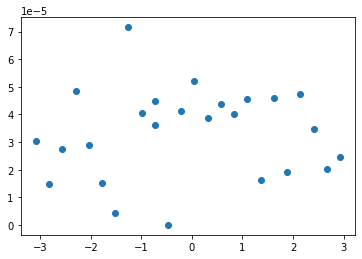

{-0.7345189695358276: (4.468466249818448e-05, nan),
 -0.4725189695358276: (0.0, nan),
 -0.2105189695358276: (4.106741653231438e-05, nan),
 0.051481030464172406: (5.216409408603795e-05, nan),
 0.3134810304641724: (3.884808029397391e-05, nan),
 0.5754810304641724: (4.361009268905036e-05, nan),
 0.8374810304641724: (4.019297375634778e-05, nan),
 1.0994810304641724: (4.573981823341455e-05, nan),
 1.3614810304641725: (1.632690145925153e-05, nan),
 1.6234810304641725: (4.577043546305504e-05, nan),
 1.8854810304641725: (1.9307921320432797e-05, nan),
 2.1474810304641725: (4.754918882099446e-05, nan),
 2.4094810304641725: (3.461327105469536e-05, nan),
 2.6714810304641725: (2.0397425032570027e-05, nan),
 2.9334810304641725: (2.469720311637502e-05, nan),
 -3.0877042767154137: (3.0385930585907772e-05, nan),
 -2.8257042767154137: (1.4806522813159972e-05, nan),
 -2.5637042767154137: (2.762370786513202e-05, nan),
 -2.3017042767154137: (4.835418440052308e-05, nan),
 -2.0397042767154137: (2.89857762254

In [26]:
# THR->ALA -- ALA at lambda = 0
run_torsion_scan(rhtf, 0, False, [6, 7, 1549, 1550], [6, 7, 10, 13], [1551, 1552], repartitioned=True)

In [ ]:
rhtf

# Generate torsion scans for the r-htf: THR->ALA lambda = 1

In [32]:
data_dir = "/data/chodera/zhangi/perses_benchmark/neq/10/13/"

with open(os.path.join(data_dir, f"13_solvent_1.pickle"), "rb") as f:
    rhtf = pickle.load(f)

In [33]:
rhtf

37.697217602596304


100%|██████████| 10000/10000 [00:04<00:00, 2484.41it/s]


3.0071301
-8461.163213452204


INFO:root:Rotating by -0.039954443947510576 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.26200000000000034 radians
INFO:root:Rotating by 0.26200000000000134 radians
INFO:root:Rotating by 0.26199999999999923 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.2620000000000001 radians
INFO:root:Rotating by 0.2620000000000001 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians


-8461.163218434833
-8461.163211996838
-8461.16319905121
-8461.163231593984
-8461.163225746433
-8461.16322555125
-8461.163219672802
-8461.163206844556
-8461.16323310148
-8461.163221719544
-8461.163235628663
-8461.163220066244
-8461.163215882867
-8461.163206282255
-8461.163220514994
-8461.163212864745
-8461.16324155215
-8461.16322898228
-8461.163220619912
-8461.163228140413
-8461.163219268343
-8461.163208689677


INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by -6.0211853071795876 radians


-8461.163217270794
-8461.163222515344
raw d: {-3.014055161152975: (-8461.163218434833, nan), -2.752055161152975: (-8461.163211996838, nan), -2.490055161152975: (-8461.16319905121, nan), -2.228055161152975: (-8461.163231593984, nan), -1.9660551611529749: (-8461.163225746433, nan), -1.7040551611529748: (-8461.16322555125, nan), -1.4420551611529748: (-8461.163219672802, nan), -1.1800551611529748: (-8461.163206844556, nan), -0.9180551611529748: (-8461.16323310148, nan), -0.6560551611529748: (-8461.163221719544, nan), -0.3940551611529748: (-8461.163235628663, nan), -0.13205516115297478: (-8461.163220066244, nan), 0.12994483884702523: (-8461.163215882867, nan), 0.39194483884702525: (-8461.163206282255, nan), 0.6539448388470253: (-8461.163220514994, nan), 0.9159448388470253: (-8461.163212864745, nan), 1.1779448388470253: (-8461.16324155215, nan), 1.4399448388470253: (-8461.16322898228, nan), 1.7019448388470253: (-8461.163220619912, nan), 1.9639448388470253: (-8461.163228140413, nan), 2.225944

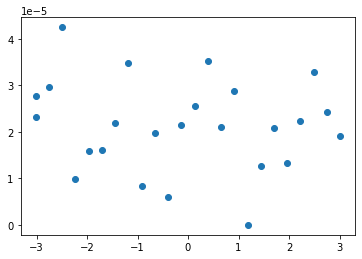

{-3.014055161152975: (2.3117318050935864e-05, nan),
 -2.752055161152975: (2.9555312721640803e-05, nan),
 -2.490055161152975: (4.250094025337603e-05, nan),
 -2.228055161152975: (9.958166629076004e-06, nan),
 -1.9660551611529749: (1.5805717339389957e-05, nan),
 -1.7040551611529748: (1.600090035935864e-05, nan),
 -1.4420551611529748: (2.1879348423681222e-05, nan),
 -1.1800551611529748: (3.470759475021623e-05, nan),
 -0.9180551611529748: (8.450670065940358e-06, nan),
 -0.6560551611529748: (1.9832606994896196e-05, nan),
 -0.3940551611529748: (5.923488060943782e-06, nan),
 -0.13205516115297478: (2.1485906472662464e-05, nan),
 0.12994483884702523: (2.5669283786555752e-05, nan),
 0.39194483884702525: (3.5269895306555554e-05, nan),
 0.6539448388470253: (2.103715632983949e-05, nan),
 0.9159448388470253: (2.8687405574601144e-05, nan),
 1.1779448388470253: (0.0, nan),
 1.4399448388470253: (1.2569871614687145e-05, nan),
 1.7019448388470253: (2.093223884003237e-05, nan),
 1.9639448388470253: (1.3411

In [28]:
# THR->ALA -- THR at lambda = 1
run_torsion_scan(rhtf, 1, True, [6, 7, 10, 12], [6, 7, 10, 12], [11, 15, 16, 17, 18, 19], repartitioned=True)